# 2-colour imaging: RecB-Halo + Nucleoid (Sytox)

In [2]:
from pyberries.data import DatasetPool
import seaborn.objects as so

data = (DatasetPool(path='D:\DanielThedie\BACMMAN\Timelapse',
                    dsList=['240424_1', '240424_2', '240424_3', '240424_4'],
                    groups=['WT, 0', 'WT, 30 ng/mL', 'ΔrecA, 0', 'ΔrecA, 30 ng/mL'],
                    metadata='DateTime'
                    )
        .heatmap_metrics(object_name=['Nucleoid', 'RecB_spots'])
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        )

Dataset 240424_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_2 (group WT, 30 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_3 (group ΔrecA, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_4 (group ΔrecA, 30 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']


In [ ]:
data.describe()

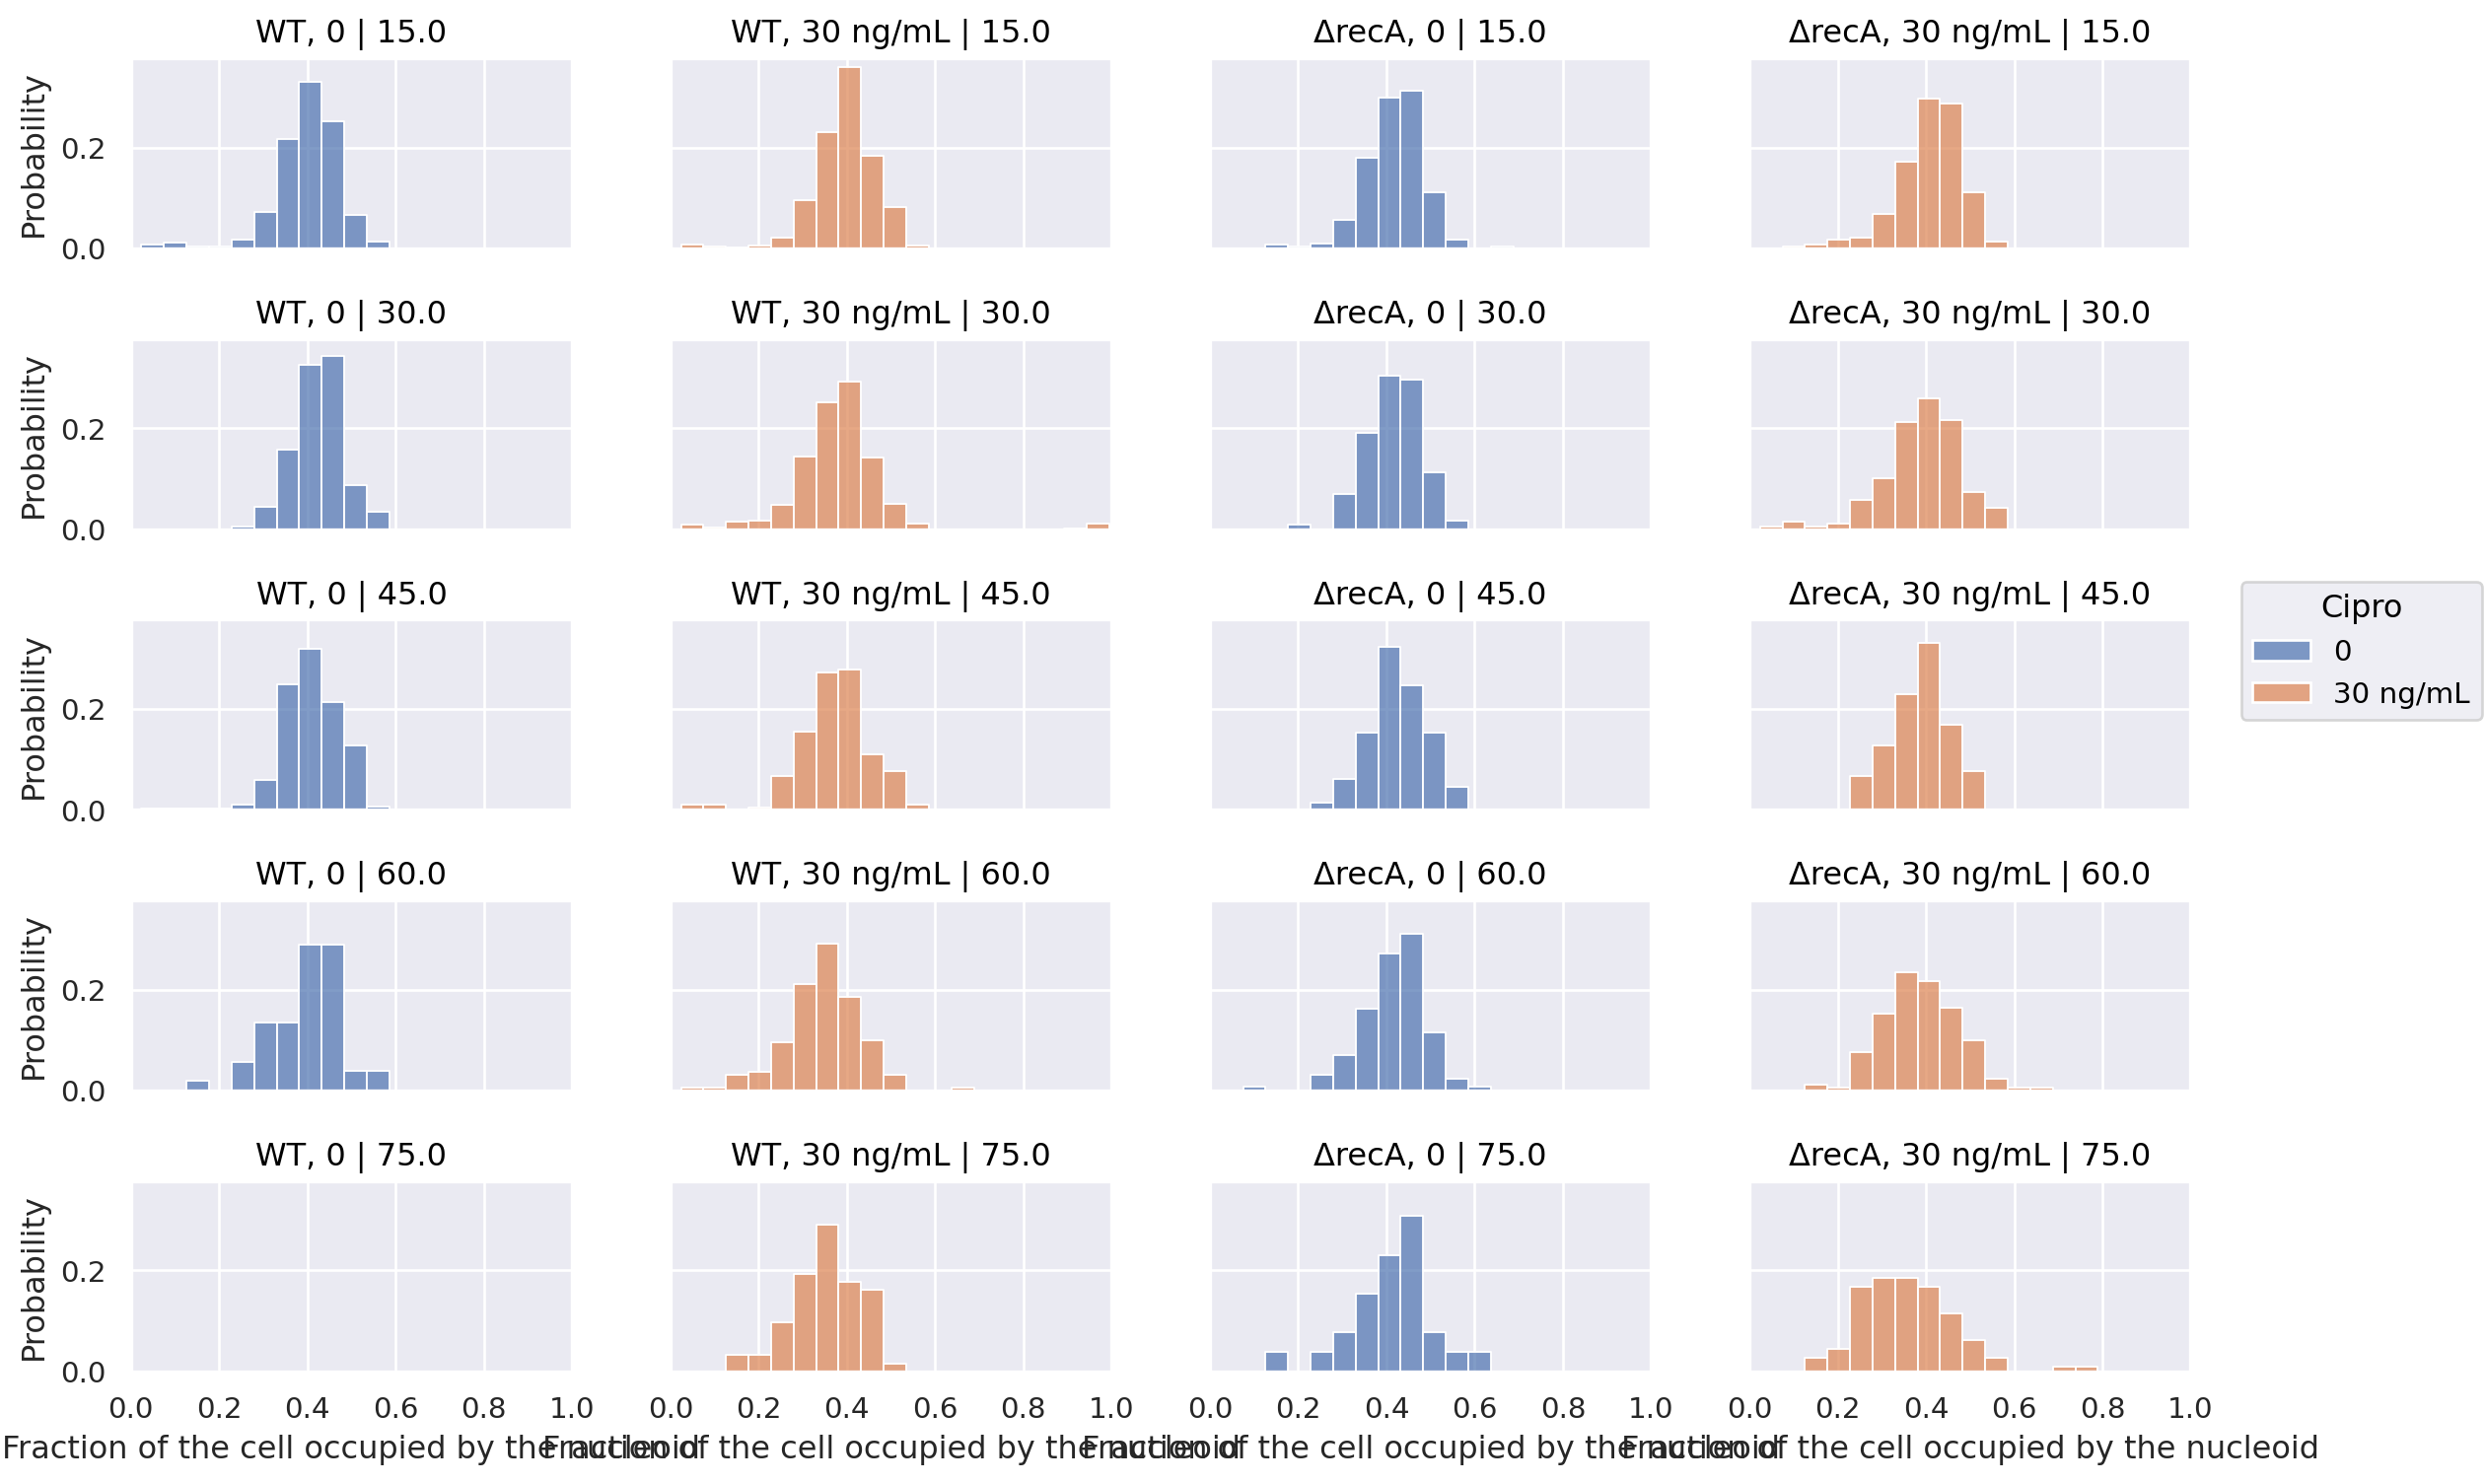

In [5]:
df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='Nucleoid_size', agg='sum')
      .Bacteria_large
      .assign(frac_nucleoid=lambda df: df.Nucleoid_size / df.Area)
      )

(
    so.Plot(df, x='frac_nucleoid', color='Cipro')
    .layout(size=(12, 8))
    .facet(row='Time_min_bin', col='Group')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.05, common_norm=False))
    .limit(x=(0, 1))
    .label(x='Fraction of the cell occupied by the nucleoid', y='Probability')
)

c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
 

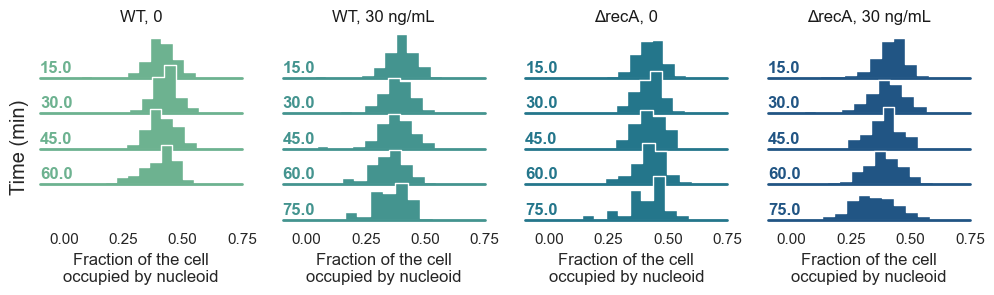

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='Nucleoid_size', agg='sum')
      .Bacteria_large
      .assign(frac_nucleoid=lambda df: df.Nucleoid_size / df.Area)
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue="Group", aspect=6, height=.5, palette='crest')
g.map(sns.histplot, 'frac_nucleoid', binwidth=0.05, common_norm=False, stat='probability', alpha=1, element='step', edgecolor='w')

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(row, color, label):
      ax = plt.gca()
      ax.text(0, .2, row.iloc[0], fontweight="bold", color=color,
              ha="left", va="center", transform=ax.transAxes)
      if row.iloc[0] == 15.0:
            ax.text(.5, 1.2, label, color='k',
                  ha="center", va="center", transform=ax.transAxes)

g.map(label, 'Time_min_bin')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.3)
g.figure.supylabel('Time (min)', x=.1, y=.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Fraction of the cell\noccupied by nucleoid', xlim=(-0.1,0.75))
g.despine(bottom=True, left=True)
plt.show()

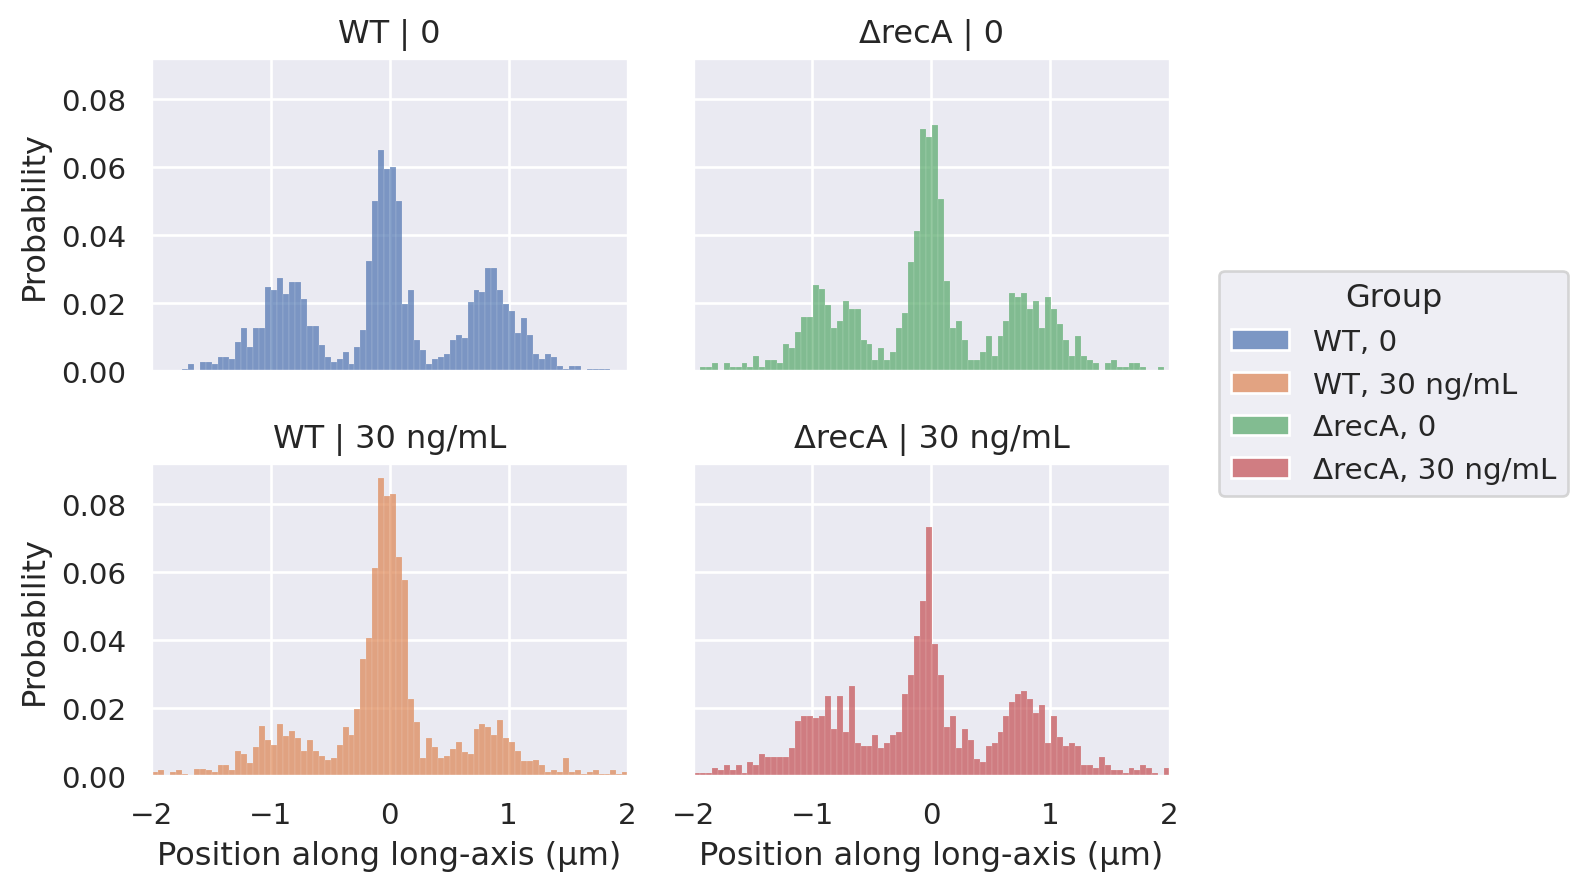

In [35]:
(
    so.Plot(data.Nucleoid, x='centerLongCoord', color='Group')
    .facet(col='Strain', row='Cipro')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.05, common_norm=False))
    .label(x='Position along long-axis (µm)', y='Probability')
    .limit(x=(-2, 2))
)

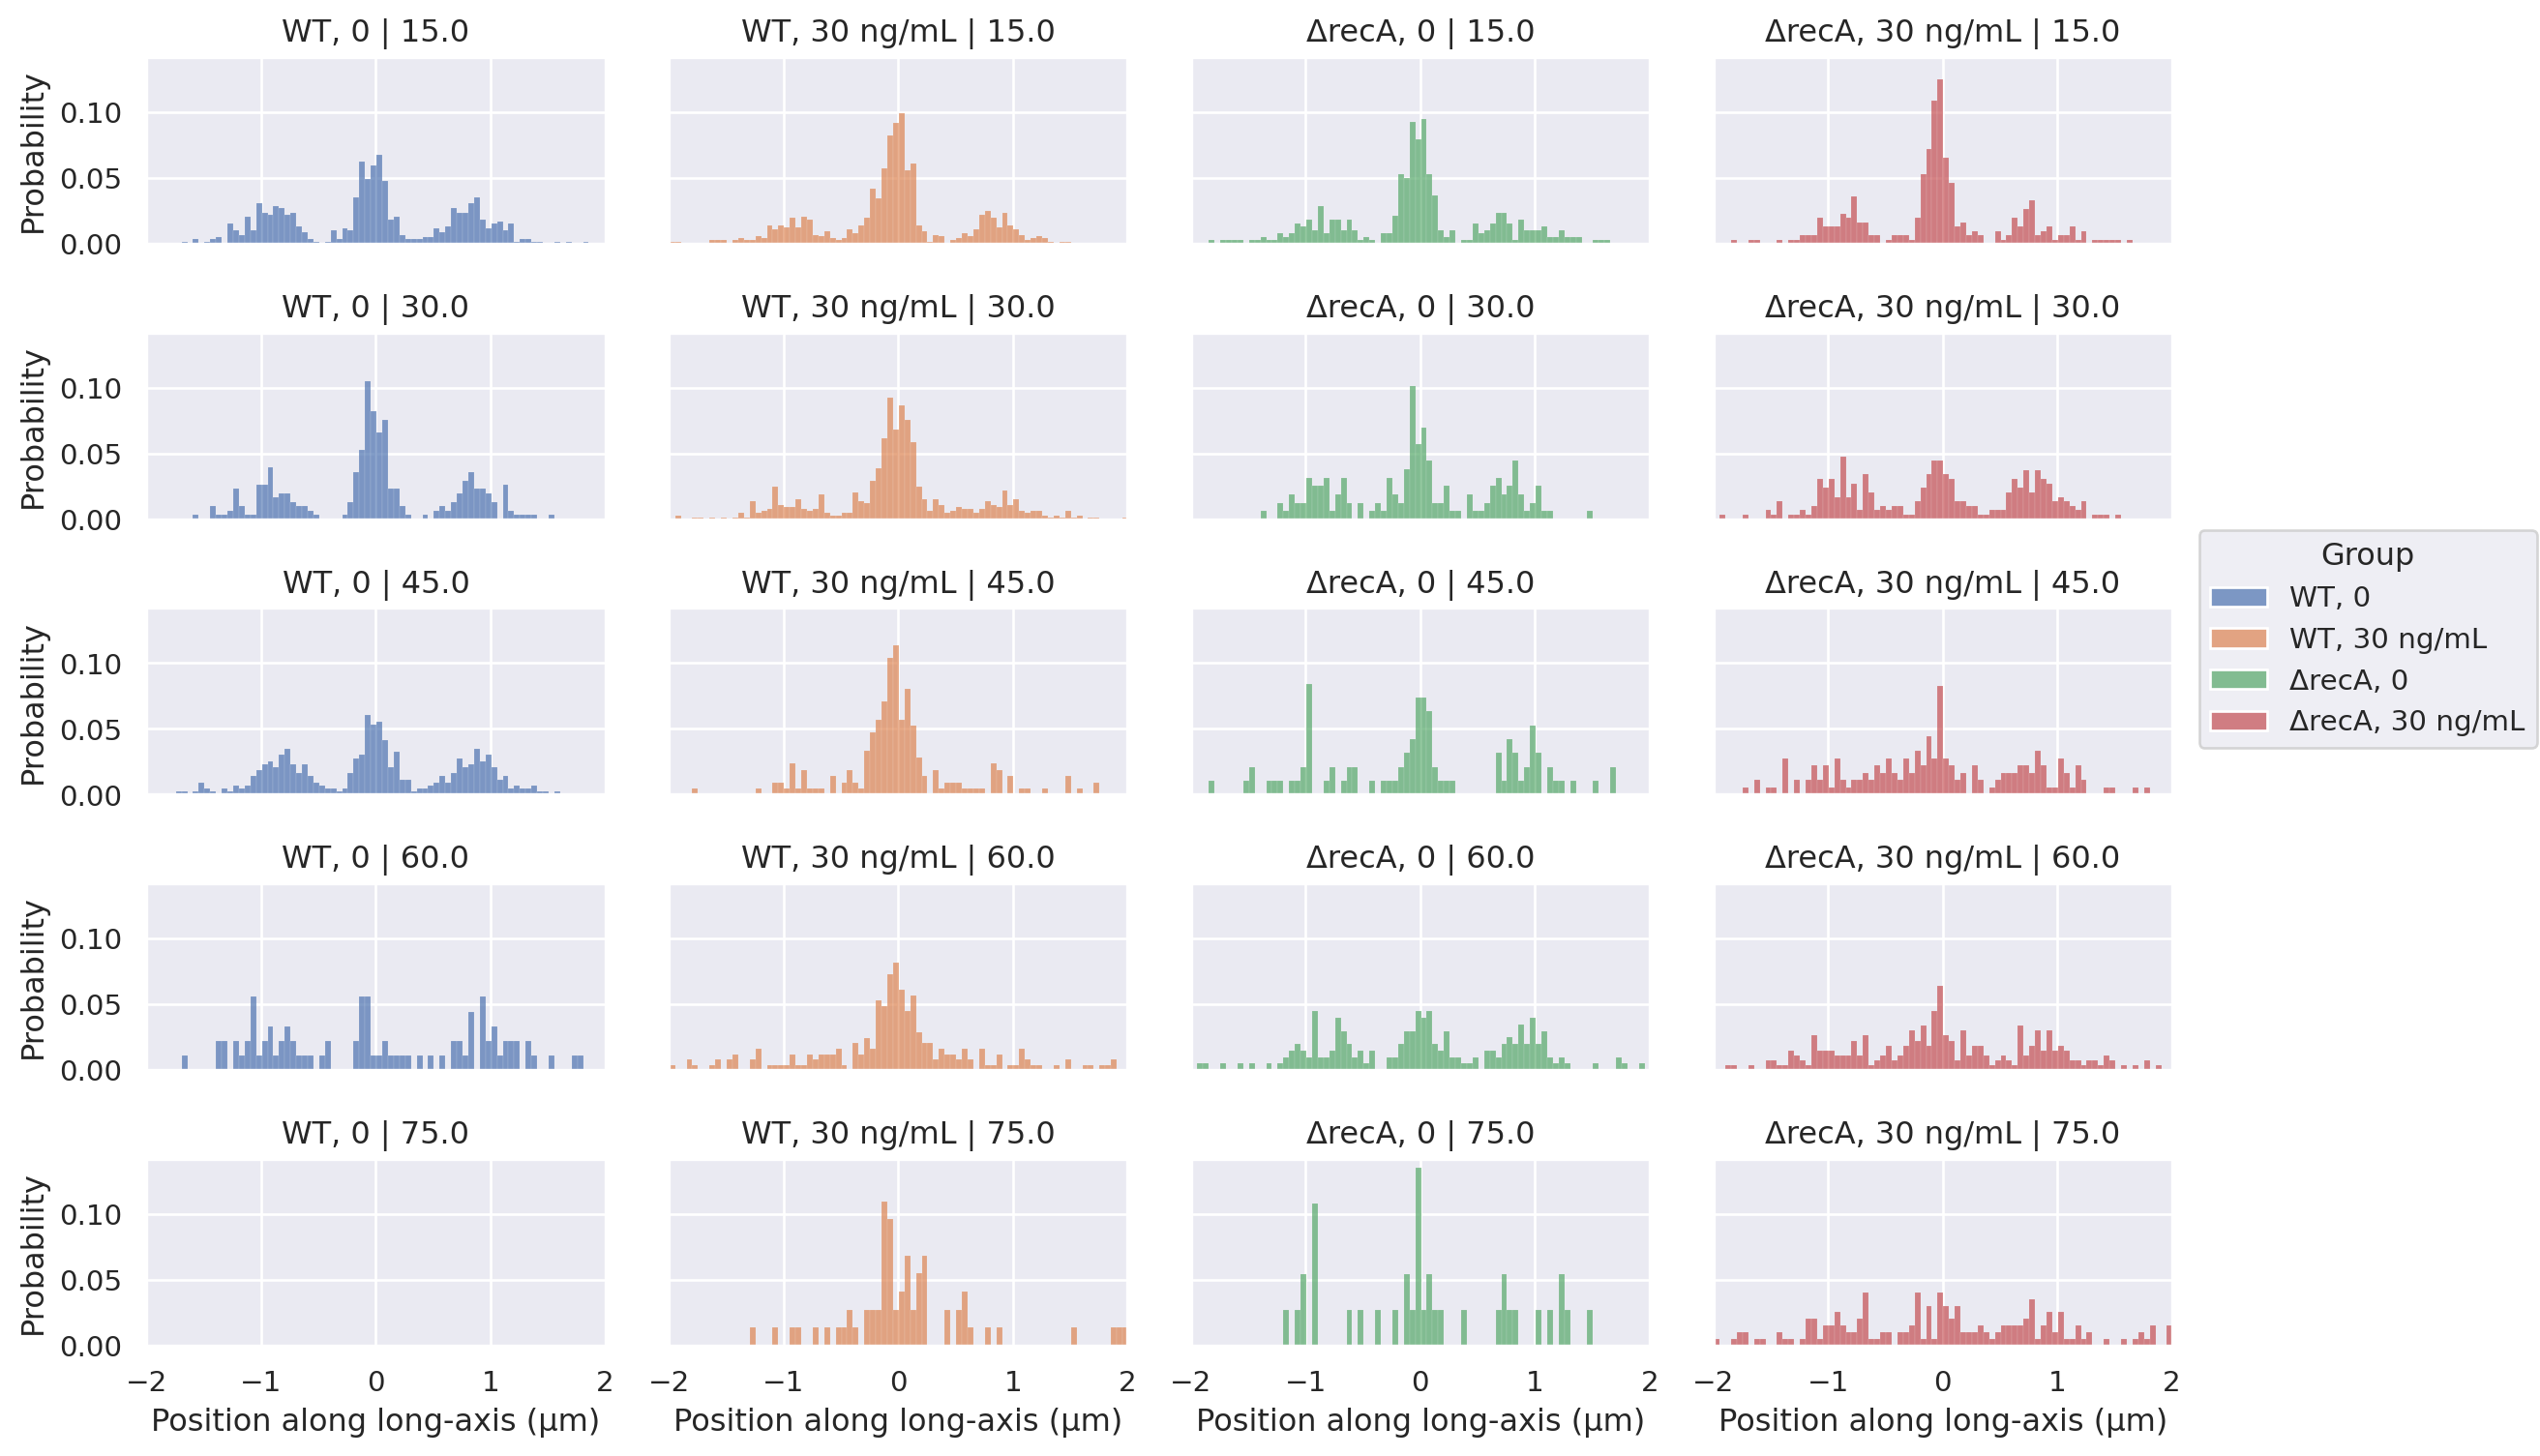

In [39]:
df = data.Nucleoid

(
    so.Plot(df, x='centerLongCoord', color='Group')
    .layout(size=(12, 8))
    .facet(row='Time_min_bin', col='Group')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.05, common_norm=False))
    .limit(x=(-2, 2))
    .label(x='Position along long-axis (µm)', y='Probability')
)

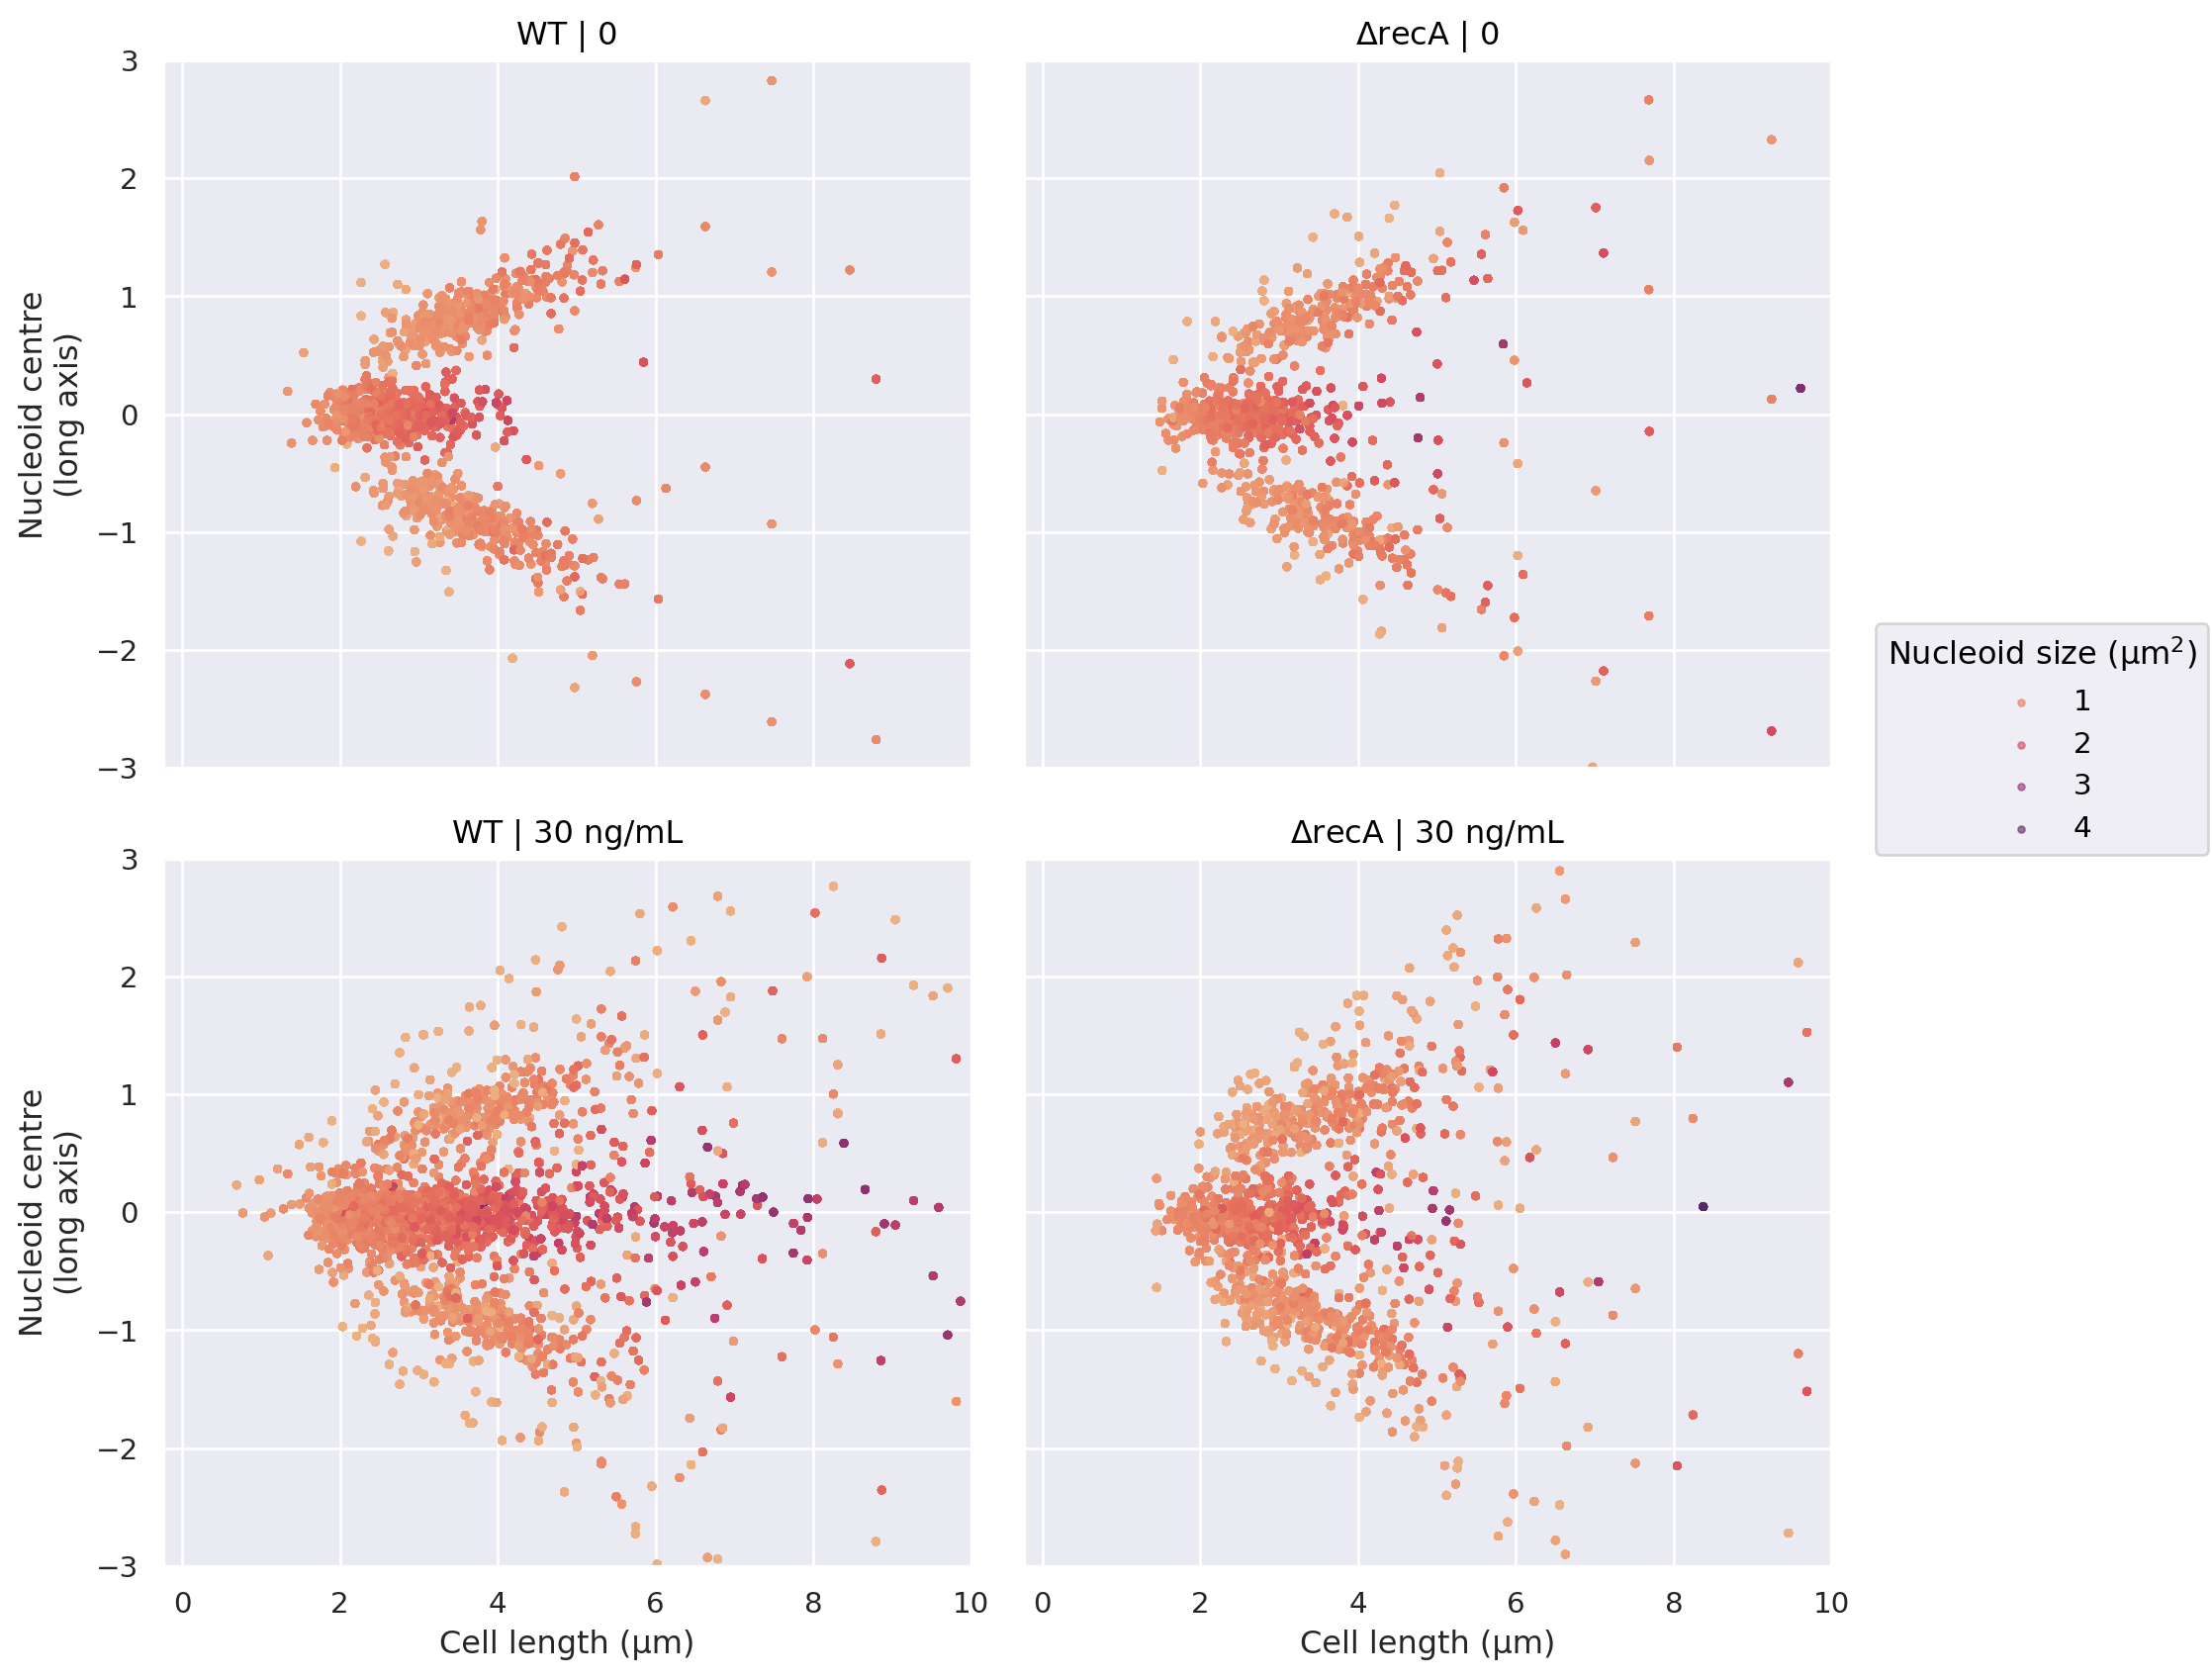

In [18]:
df = (data
      .Nucleoid
      )

(
    so.Plot(df, x='SpineLength', y='centerLongCoord', color='Nucleoid_size')
    .layout(size=(10,9))
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.', alpha=.6, fillalpha=.6, pointsize=5))
    .limit(x=(None, 10), y=(-3, 3))
    .scale(color='flare')
    .label(x='Cell length (µm)', y='Nucleoid centre\n(long axis)', color='Nucleoid size (µm$^2$)')
)

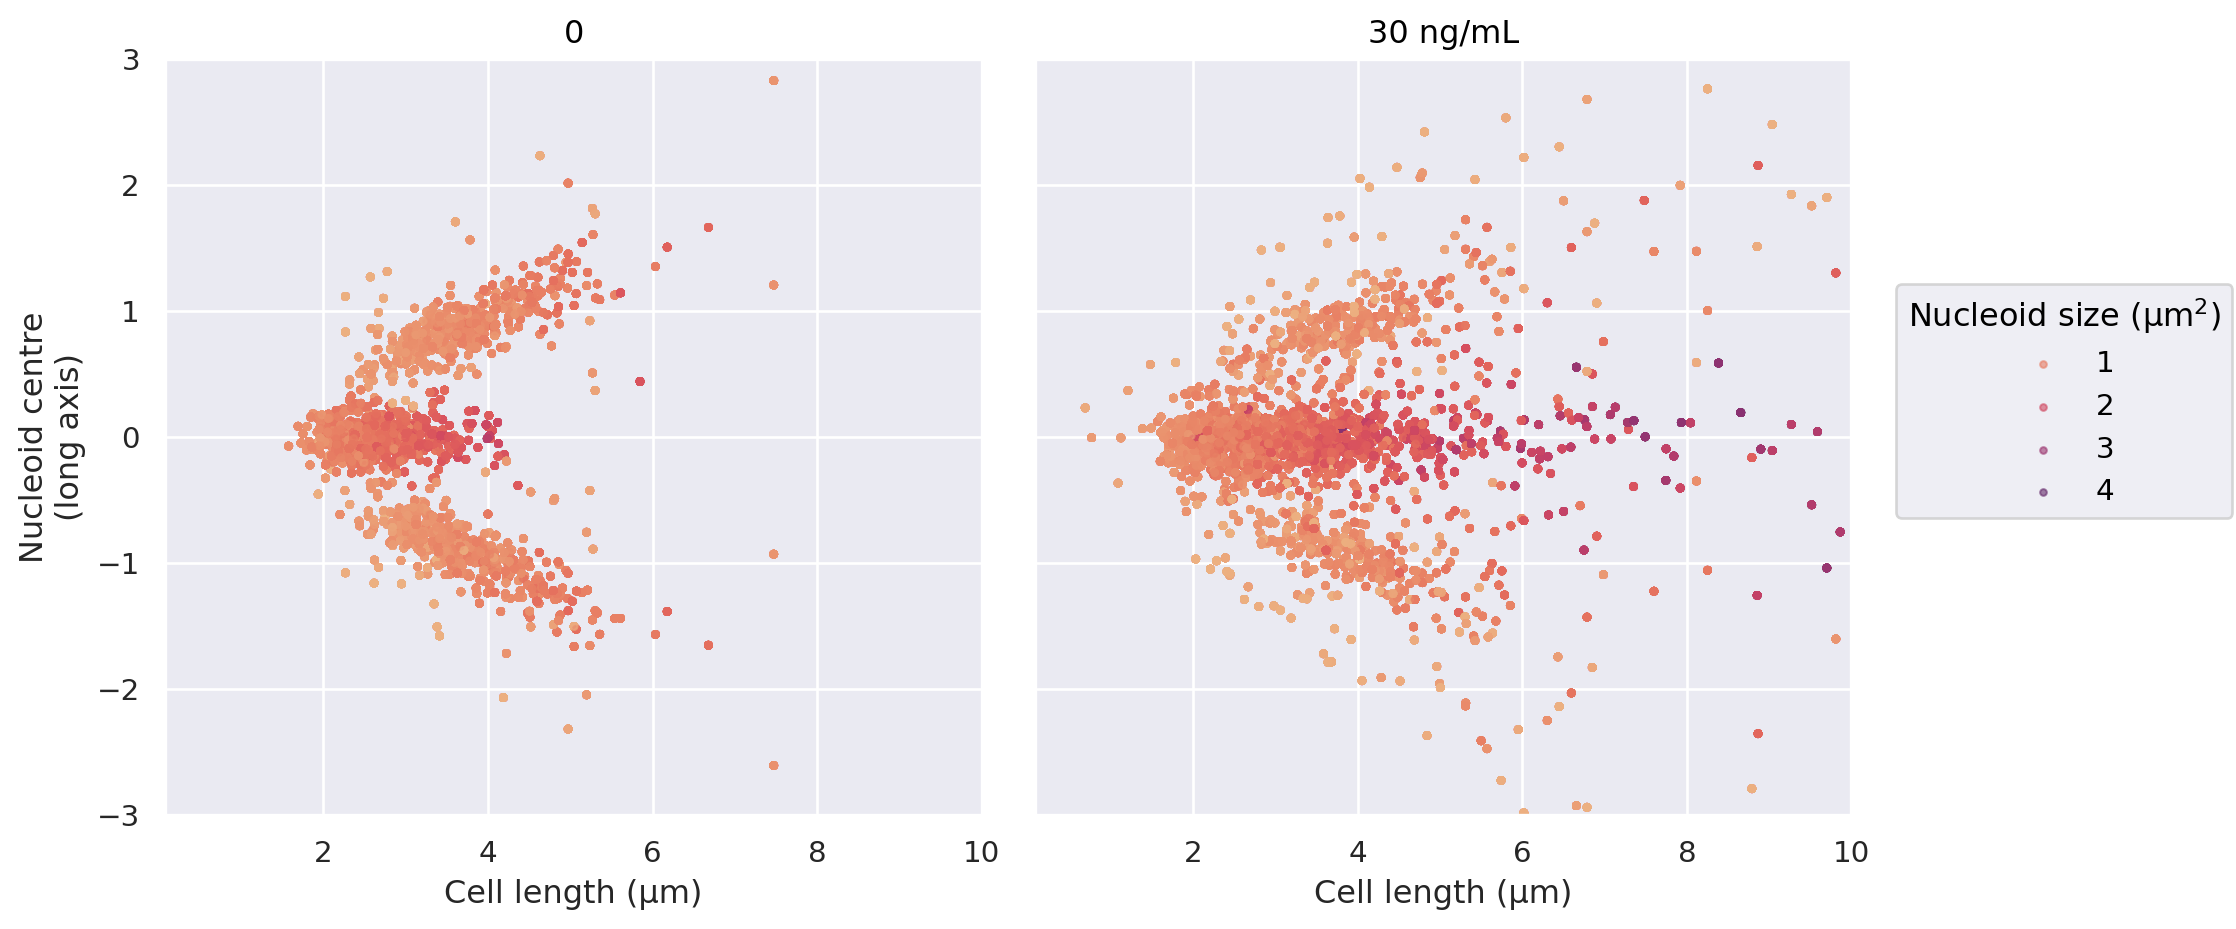

In [4]:
df = (data
      .Nucleoid
      .query('Strain == "WT"')
      )

(
    so.Plot(df, x='SpineLength', y='centerLongCoord', color='Nucleoid_size')
    .layout(size=(10,5))
    .facet(col='Cipro')
    .add(so.Dots(marker='.', alpha=.6, fillalpha=.6, pointsize=5))
    .limit(x=(None, 10), y=(-3, 3))
    .scale(color='flare')
    .label(x='Cell length (µm)', y='Nucleoid centre\n(long axis)', color='Nucleoid size (µm$^2$)')
)

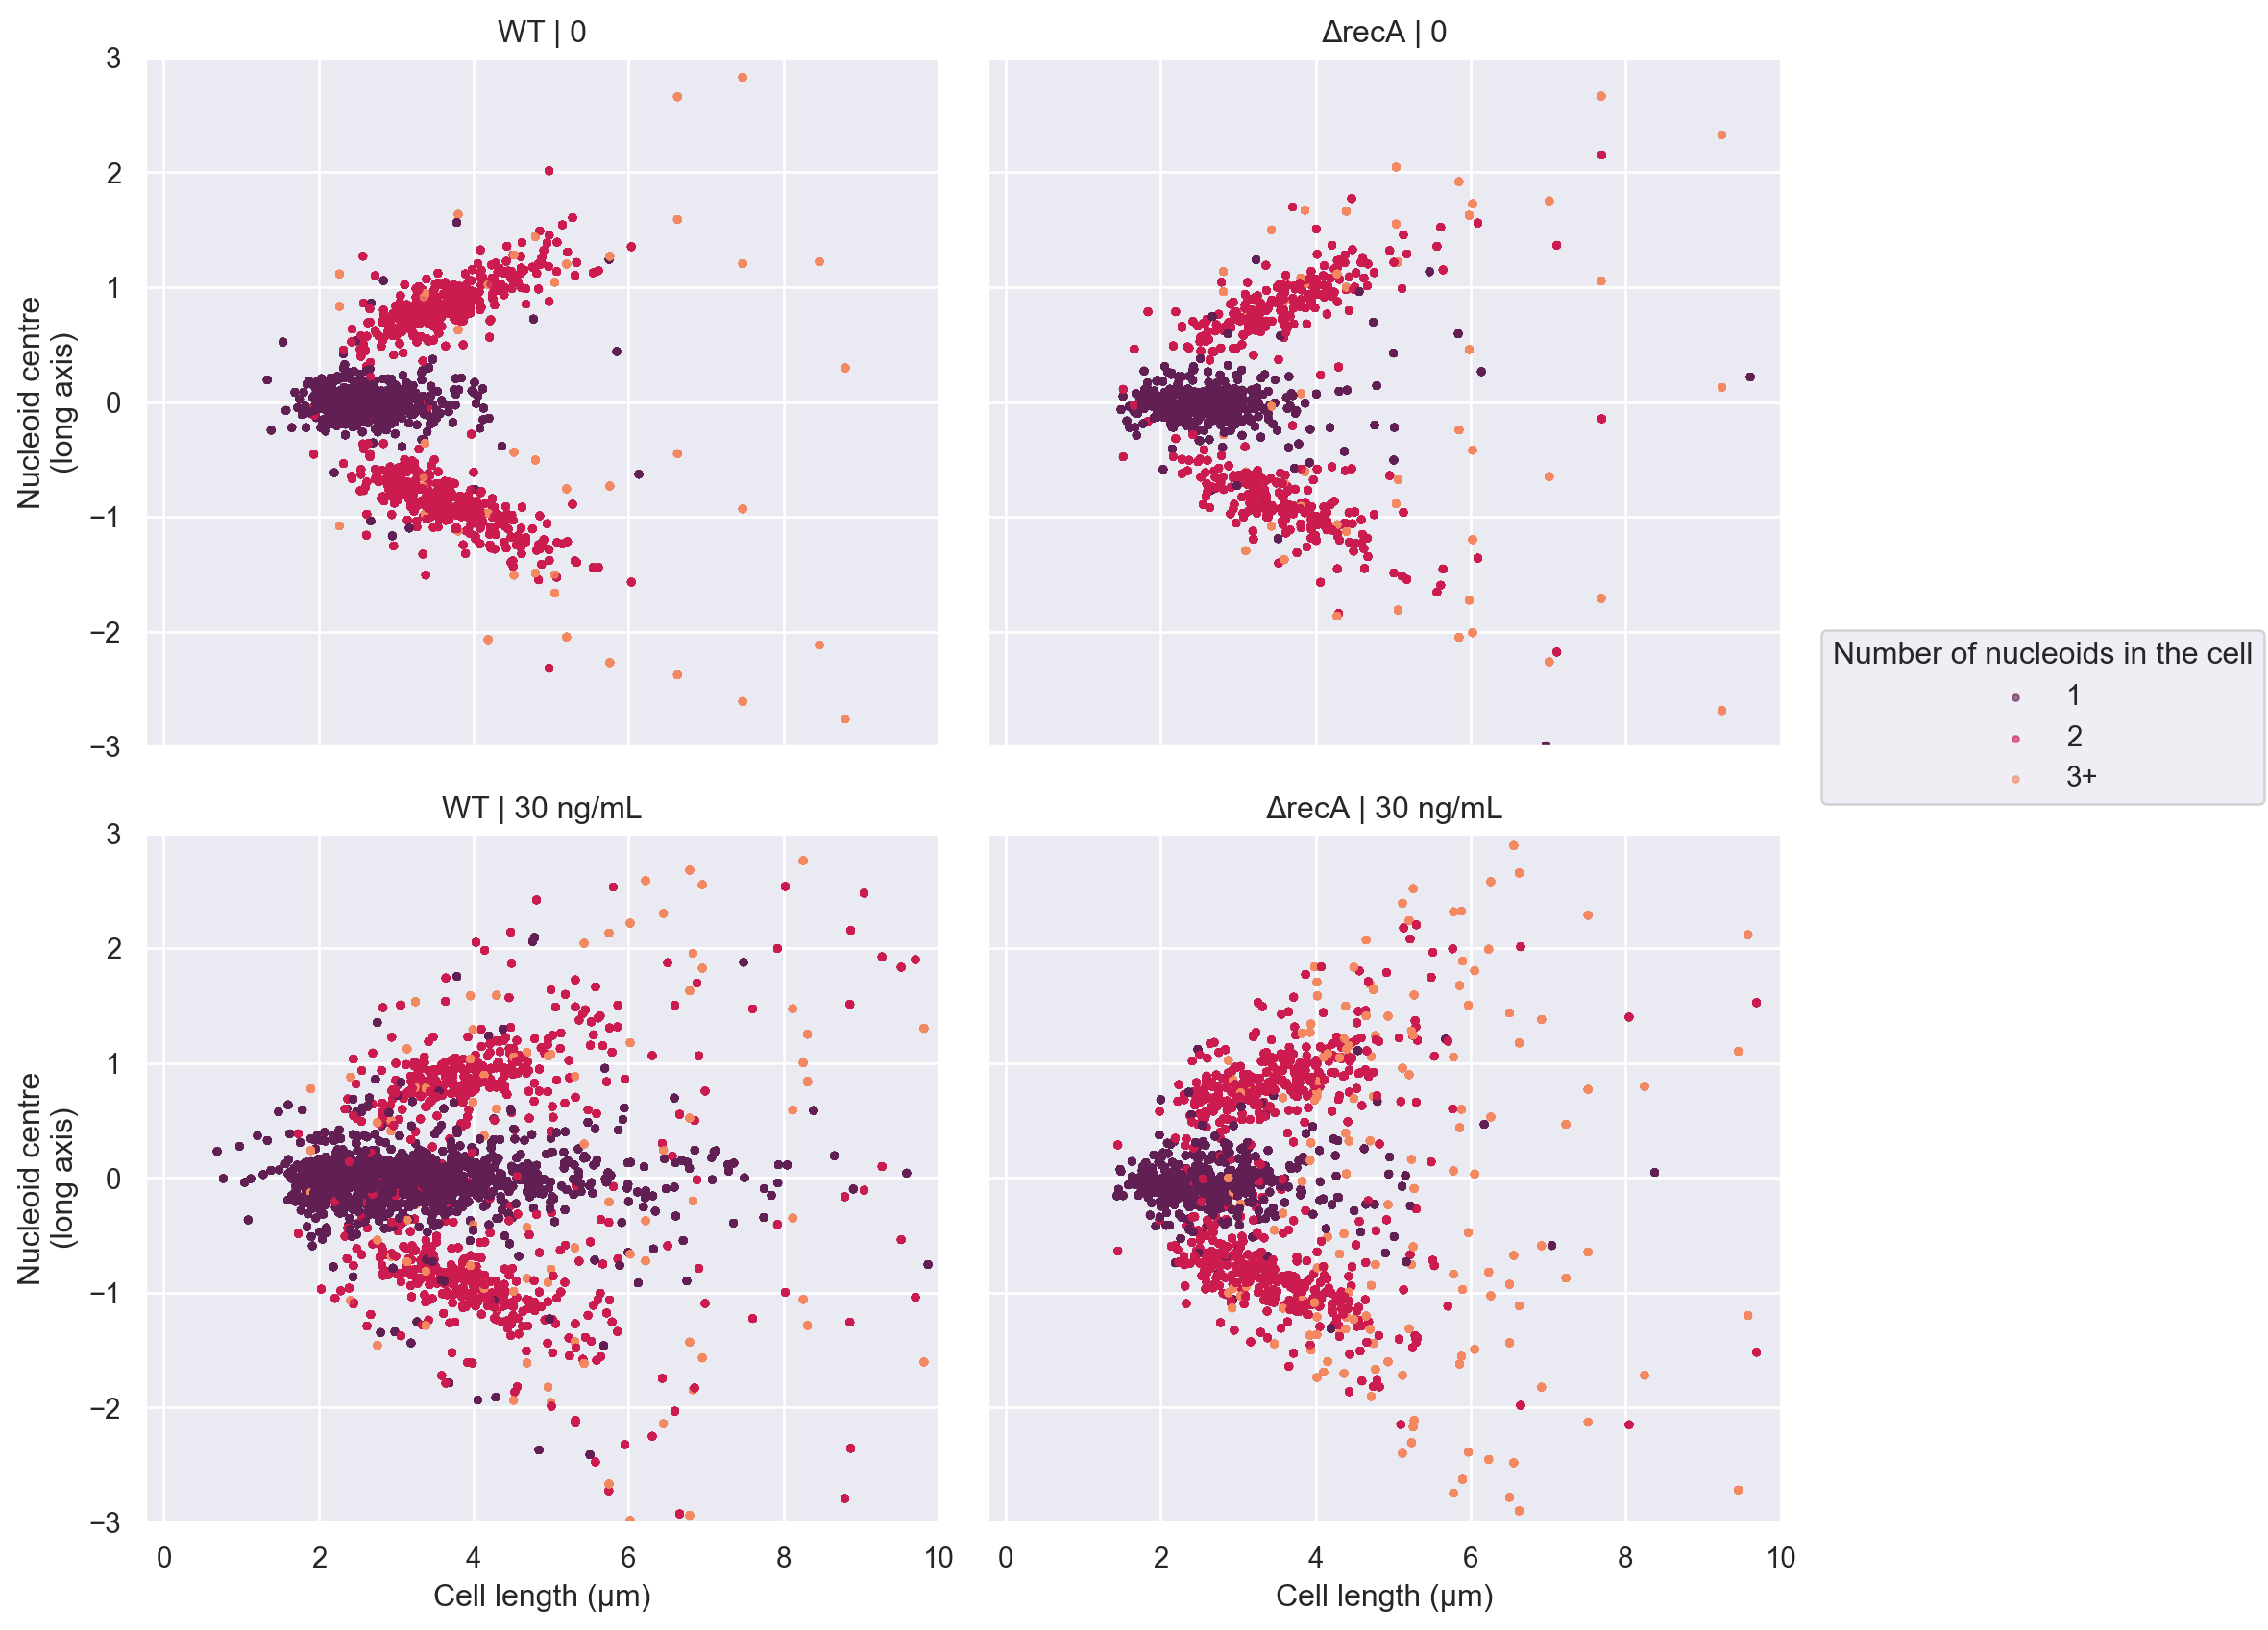

In [196]:
df = (data
      .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
      .Nucleoid
      .assign(NucleoidCount=lambda df: df.NucleoidCount.astype('str').replace({'3':'3+', '4':'3+', '5':'3+'}))
      )

(
    so.Plot(df, x='SpineLength', y='centerLongCoord', color='NucleoidCount')
    .layout(size=(10,9))
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.', alpha=.6, fillalpha=.6, pointsize=5))
    .limit(x=(None, 10), y=(-3, 3))
    .scale(color=so.Nominal('rocket', order=['1', '2', '3+']))
    .label(x='Cell length (µm)', y='Nucleoid centre\n(long axis)', color='Number of nucleoids in the cell')
)

In [12]:
df = (data
      .Bacteria_large
      .assign(no_nucleoid=lambda df: df.NucleoidCount.eq(0).astype('int')*100,
              )
      .groupby(['Strain', 'Cipro'])
      .agg({'no_nucleoid':'mean'})
      .assign(no_nucleoid=lambda df: df.no_nucleoid.astype('int').astype('str') + '%')
      .rename(columns={'no_nucleoid':'Cells with no nucleoid'})
      )

display(df)

Cells with no nucleoid
Strain Cipro                          
WT     0                            0%
       30 ng/mL                     3%
ΔrecA  0                            5%
       30 ng/mL                     2%

In [9]:
df = (data
      .RecB_spots
      .assign(spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int')*100,
              long_spot=lambda df: df.TrackLength.ge(5)
              )
      .query('long_spot == True')
      .groupby(['Strain', 'Cipro'])
      .agg({'spot_in_nucleoid':'mean'})
      .assign(spot_in_nucleoid=lambda df: df.spot_in_nucleoid.astype('int').astype('str') + '%')
      .rename(columns={'spot_in_nucleoid':'DNA-bound RecB in a nucleoid'})
      )

display(df)

DNA-bound RecB in a nucleoid
Strain Cipro                                
WT     0                                 70%
       30 ng/mL                          79%
ΔrecA  0                                 75%
       30 ng/mL                          82%

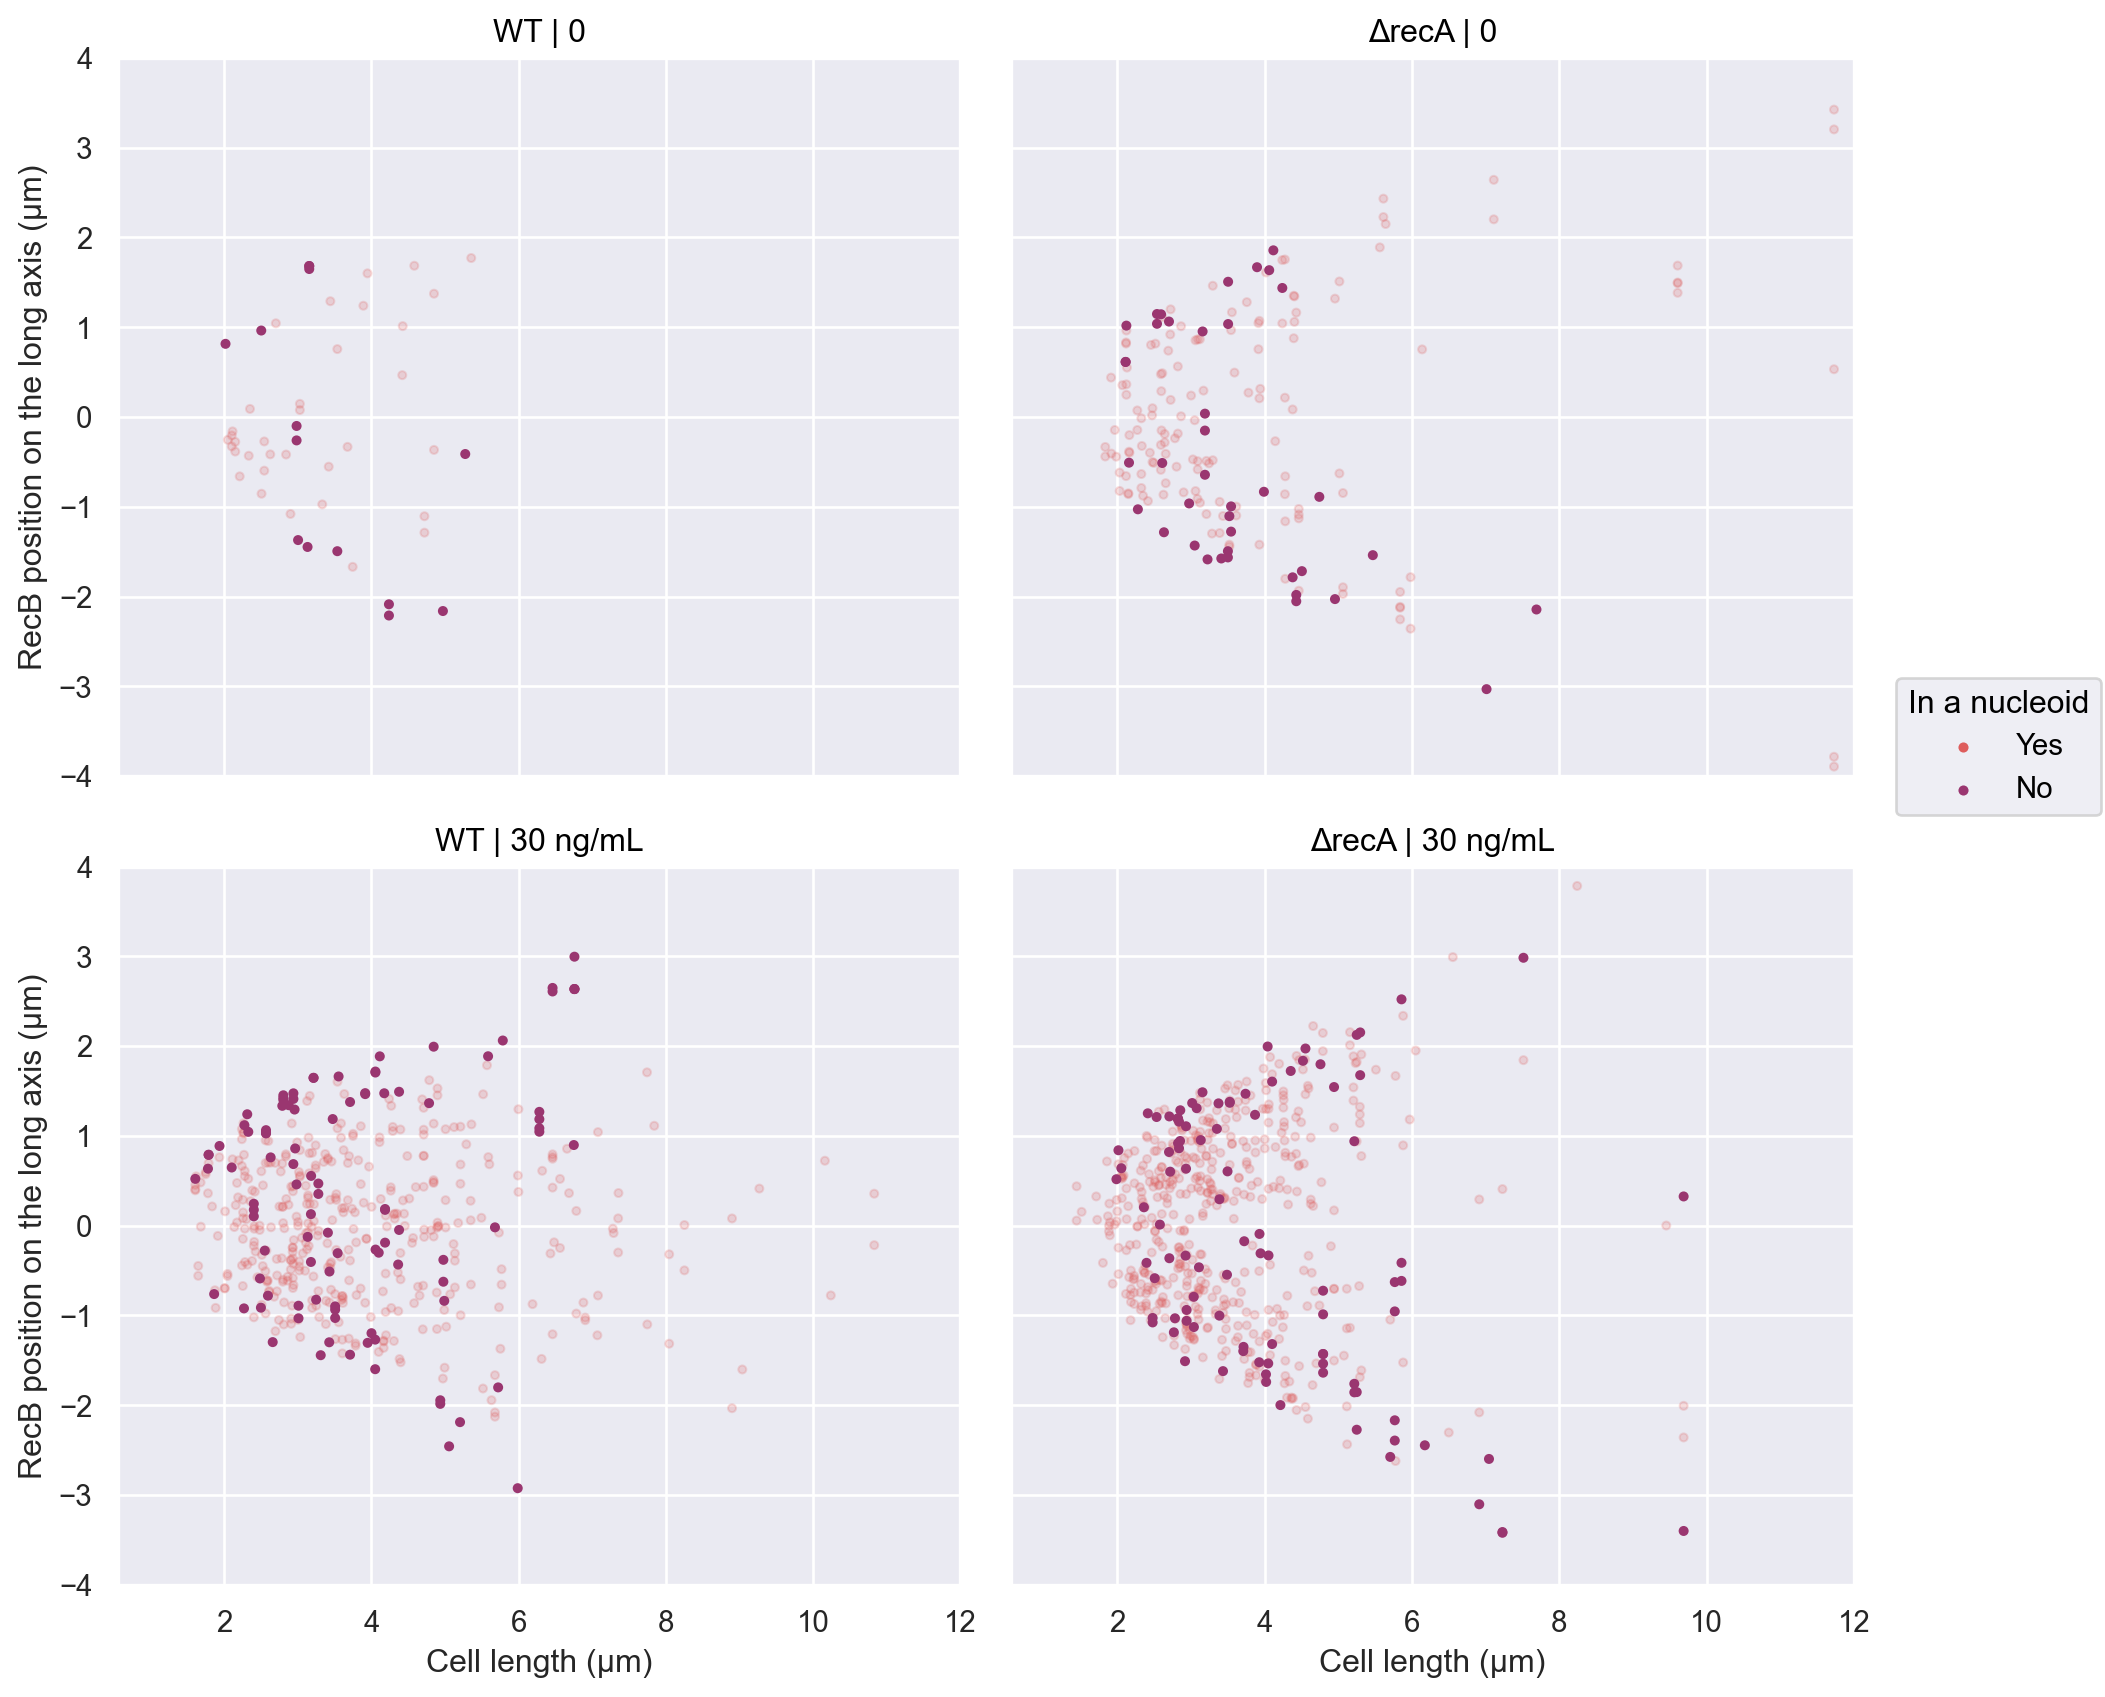

In [2]:
df = (data
      .apply_filters({'RecB_spots':'TrackLength >= 5'})
      .assign(object_name='RecB_spots', spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'))
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['centerLongCoord', 'spot_in_nucleoid'], child='RecB_spots', agg='first', rename=['RecB_pos', 'in_nucleoid'])
      .Bacteria_large
      .assign(in_nucleoid=lambda df: df.in_nucleoid.replace({0:'No', 1:'Yes'}))
      )

(
    so.Plot(df, x='SpineLength', y='RecB_pos', color='in_nucleoid')
    .layout(size=(10,9))
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.', alpha=.2, fillalpha=.2, pointsize=6), data=df.query('in_nucleoid == "Yes"'))
    .add(so.Dots(marker='.', alpha=1, fillalpha=1, pointsize=6), data=df.query('in_nucleoid == "No"'))
    .limit(x=(None, 12), y=(-4, 4))
    .scale(color='flare')
    .label(x='Cell length (µm)', y='RecB position on the long axis (µm)', color='In a nucleoid')
)

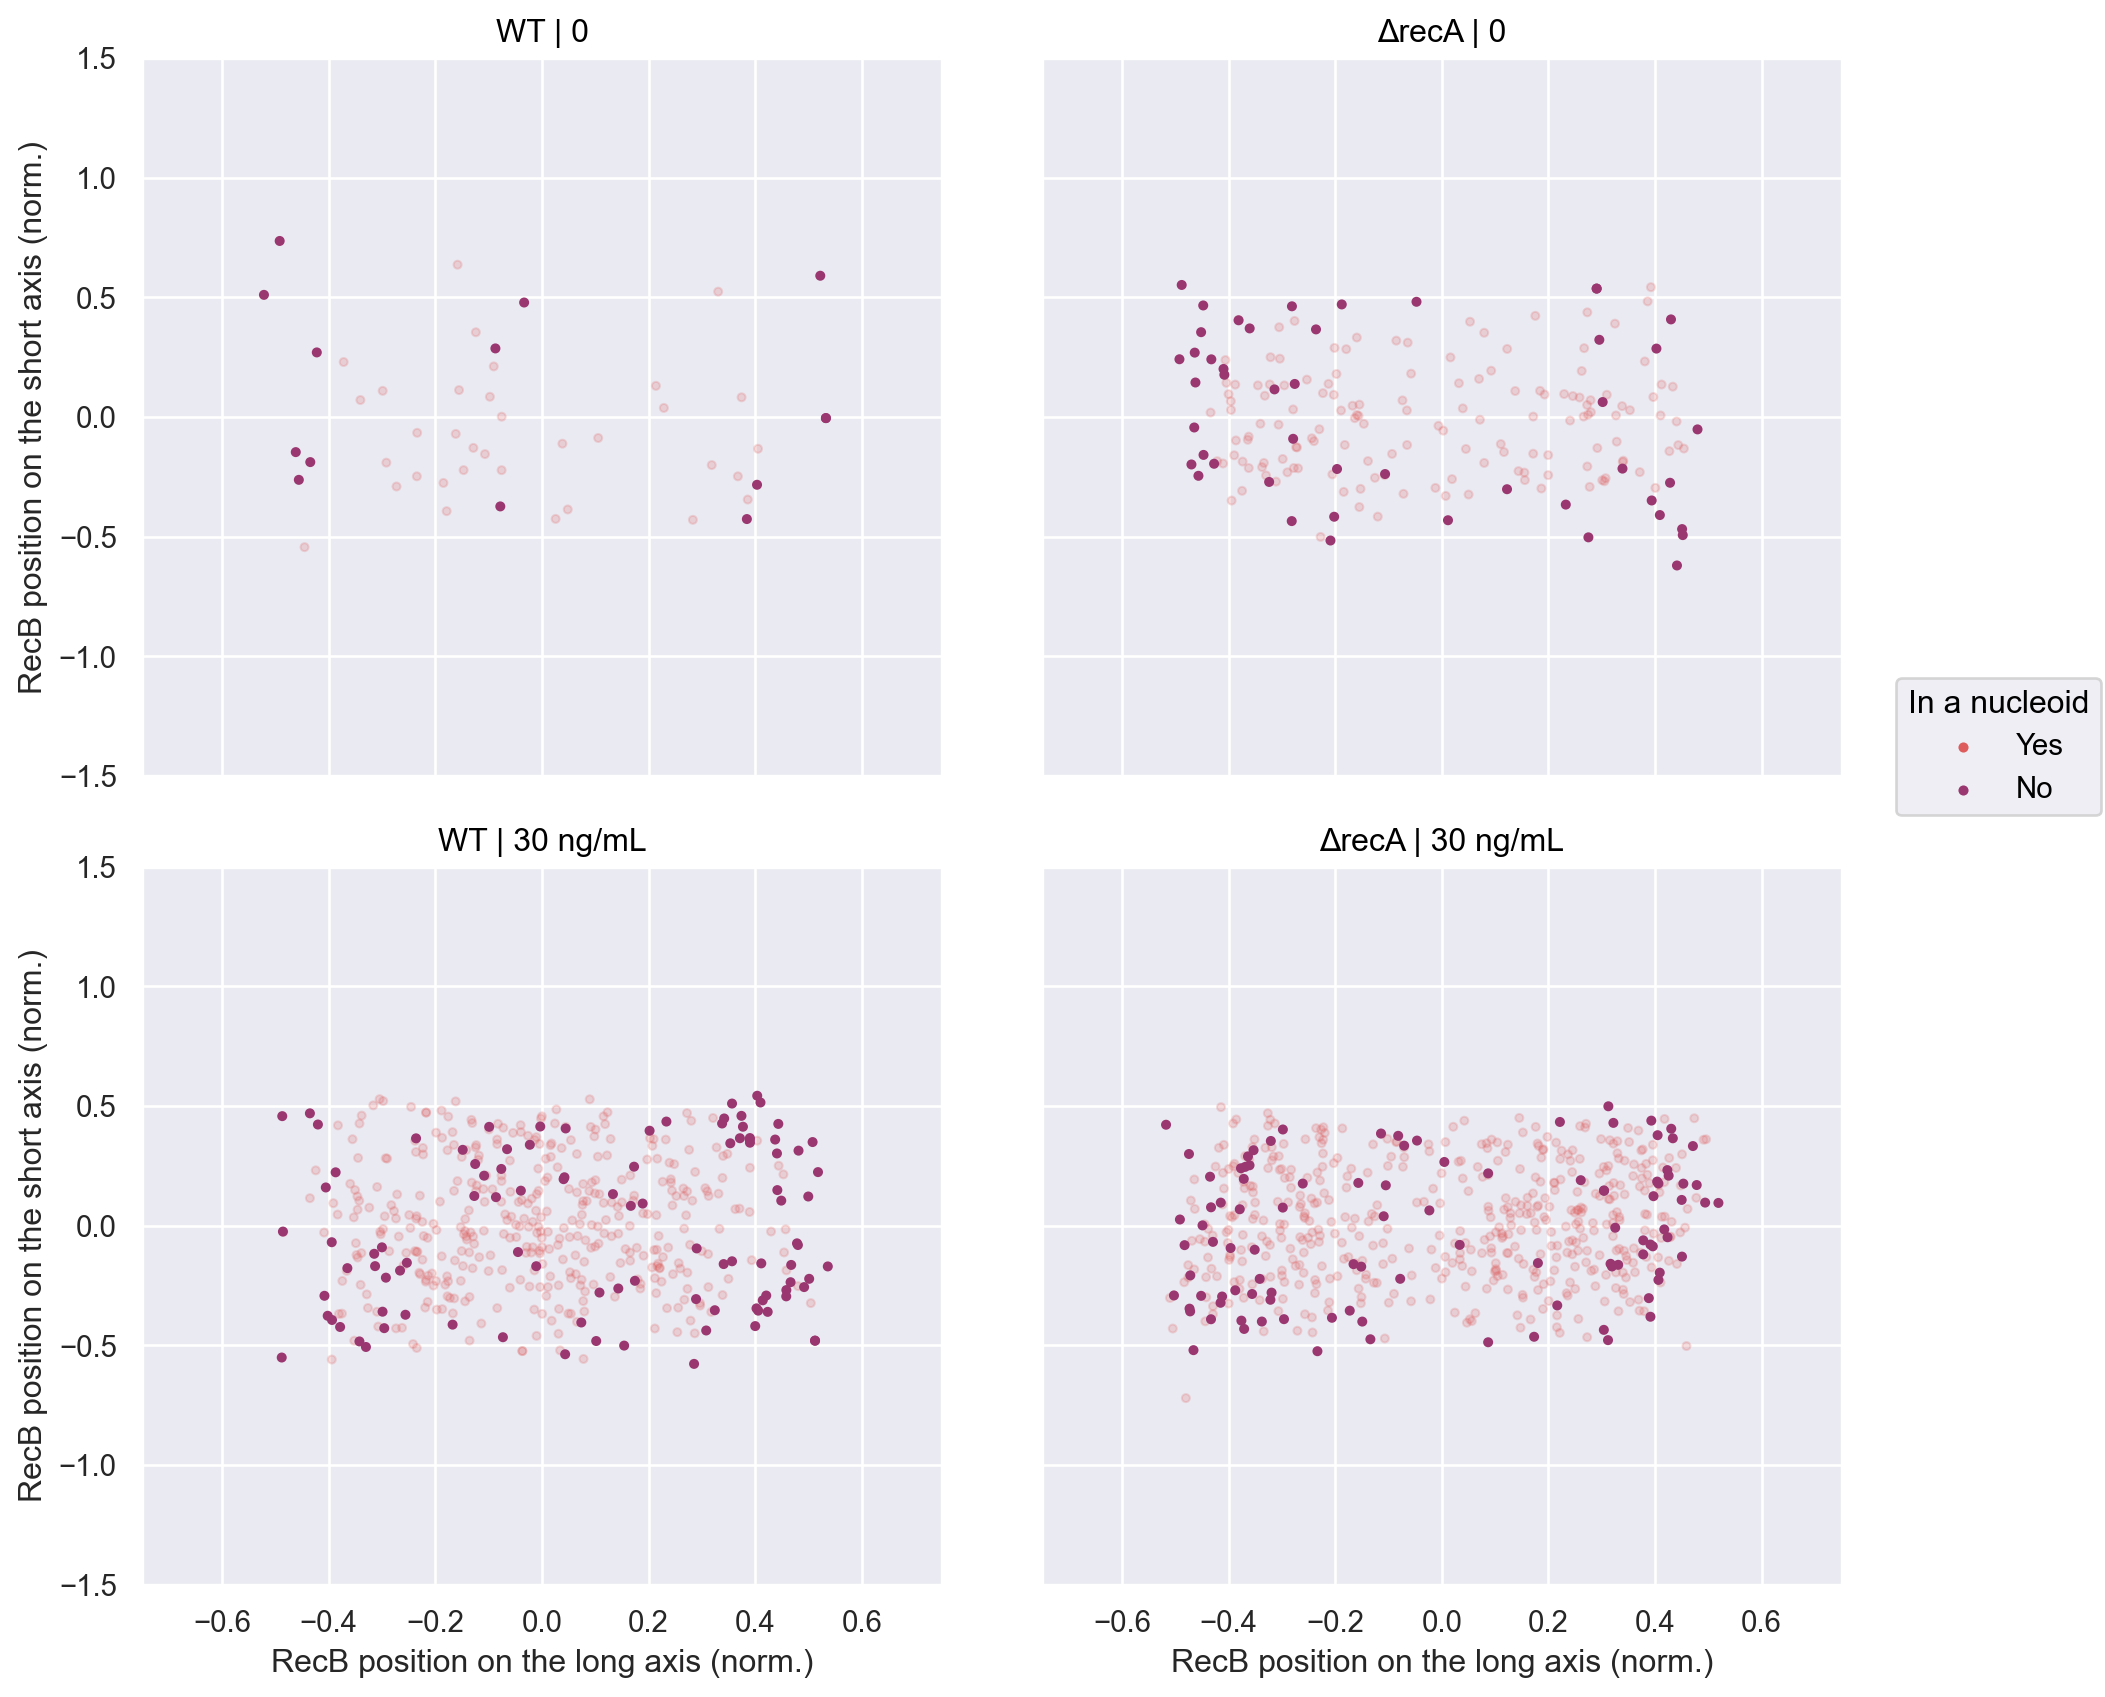

In [9]:
df = (data
      .apply_filters({'RecB_spots':'TrackLength >= 5'})
      .assign(object_name='RecB_spots', spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'))
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['normLongCoord', 'normShortCoord', 'spot_in_nucleoid'], child='RecB_spots', agg='first', rename=['RecB_long', 'RecB_short', 'in_nucleoid'])
      .Bacteria_large
      .assign(in_nucleoid=lambda df: df.in_nucleoid.replace({0:'No', 1:'Yes'}))
      )

(
    so.Plot(df, x='RecB_long', y='RecB_short', color='in_nucleoid')
    .layout(size=(10,9))
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.', alpha=.2, fillalpha=.2, pointsize=6), data=df.query('in_nucleoid == "Yes"'))
    .add(so.Dots(marker='.', alpha=1, fillalpha=1, pointsize=6), data=df.query('in_nucleoid == "No"'))
    .limit(x=(-.75, .75), y=(-1.5, 1.5))
    .scale(color='flare')
    .label(x='RecB position on the long axis (norm.)', y='RecB position on the short axis (norm.)', color='In a nucleoid')
)

c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
 

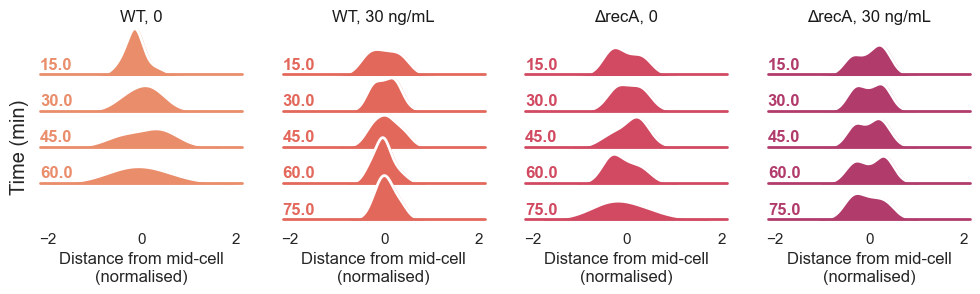

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .heatmap_metrics(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
      .RecB_spots
      .query('Time_min_bin < 90 and TrackLength >= 5')
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue='Group', aspect=6, height=.5, palette=sns.color_palette('flare'))

# Draw the densities in a few steps
g.map(sns.kdeplot, "normLongCoord",
      bw_adjust=1.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "normLongCoord", clip_on=False, color="w", lw=2, bw_adjust=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(row, color, label):
      ax = plt.gca()
      ax.text(0, .2, row.iloc[0], fontweight="bold", color=color,
              ha="left", va="center", transform=ax.transAxes)
      if row.iloc[0] == 15.0:
            ax.text(.5, 1.2, label, color='k',
                  ha="center", va="center", transform=ax.transAxes)

g.map(label, 'Time_min_bin')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)
g.figure.supylabel('Time (min)', x=.1, y=.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Distance from mid-cell\n(normalised)')
g.despine(bottom=True, left=True)
plt.show()

In [5]:
from pybacmman.selections import store_selection

df = (data
      .apply_filters({'RecB_spots':'TrackLength >= 5'})
      .assign(object_name='RecB_spots', spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'))
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['spot_in_nucleoid'], child='RecB_spots', agg='first', rename=['in_nucleoid'])
      .Bacteria_large
      .assign(in_nucleoid=lambda df: df.in_nucleoid.replace({0:'No', 1:'Yes'}))
      .query('Dataset == "240424_2" and in_nucleoid == "No"')
      )

store_selection(df,
            #     dsPath='D:\\Daniel\\BACMMAN\\Timelapse',
                dsName="Timelapse\\240424_2",
                objectClassIdx=0,
                selectionName='Spot_non_nucleoid',
                port=25333, python_proxy_port=25334, address='127.0.0.1'
                )

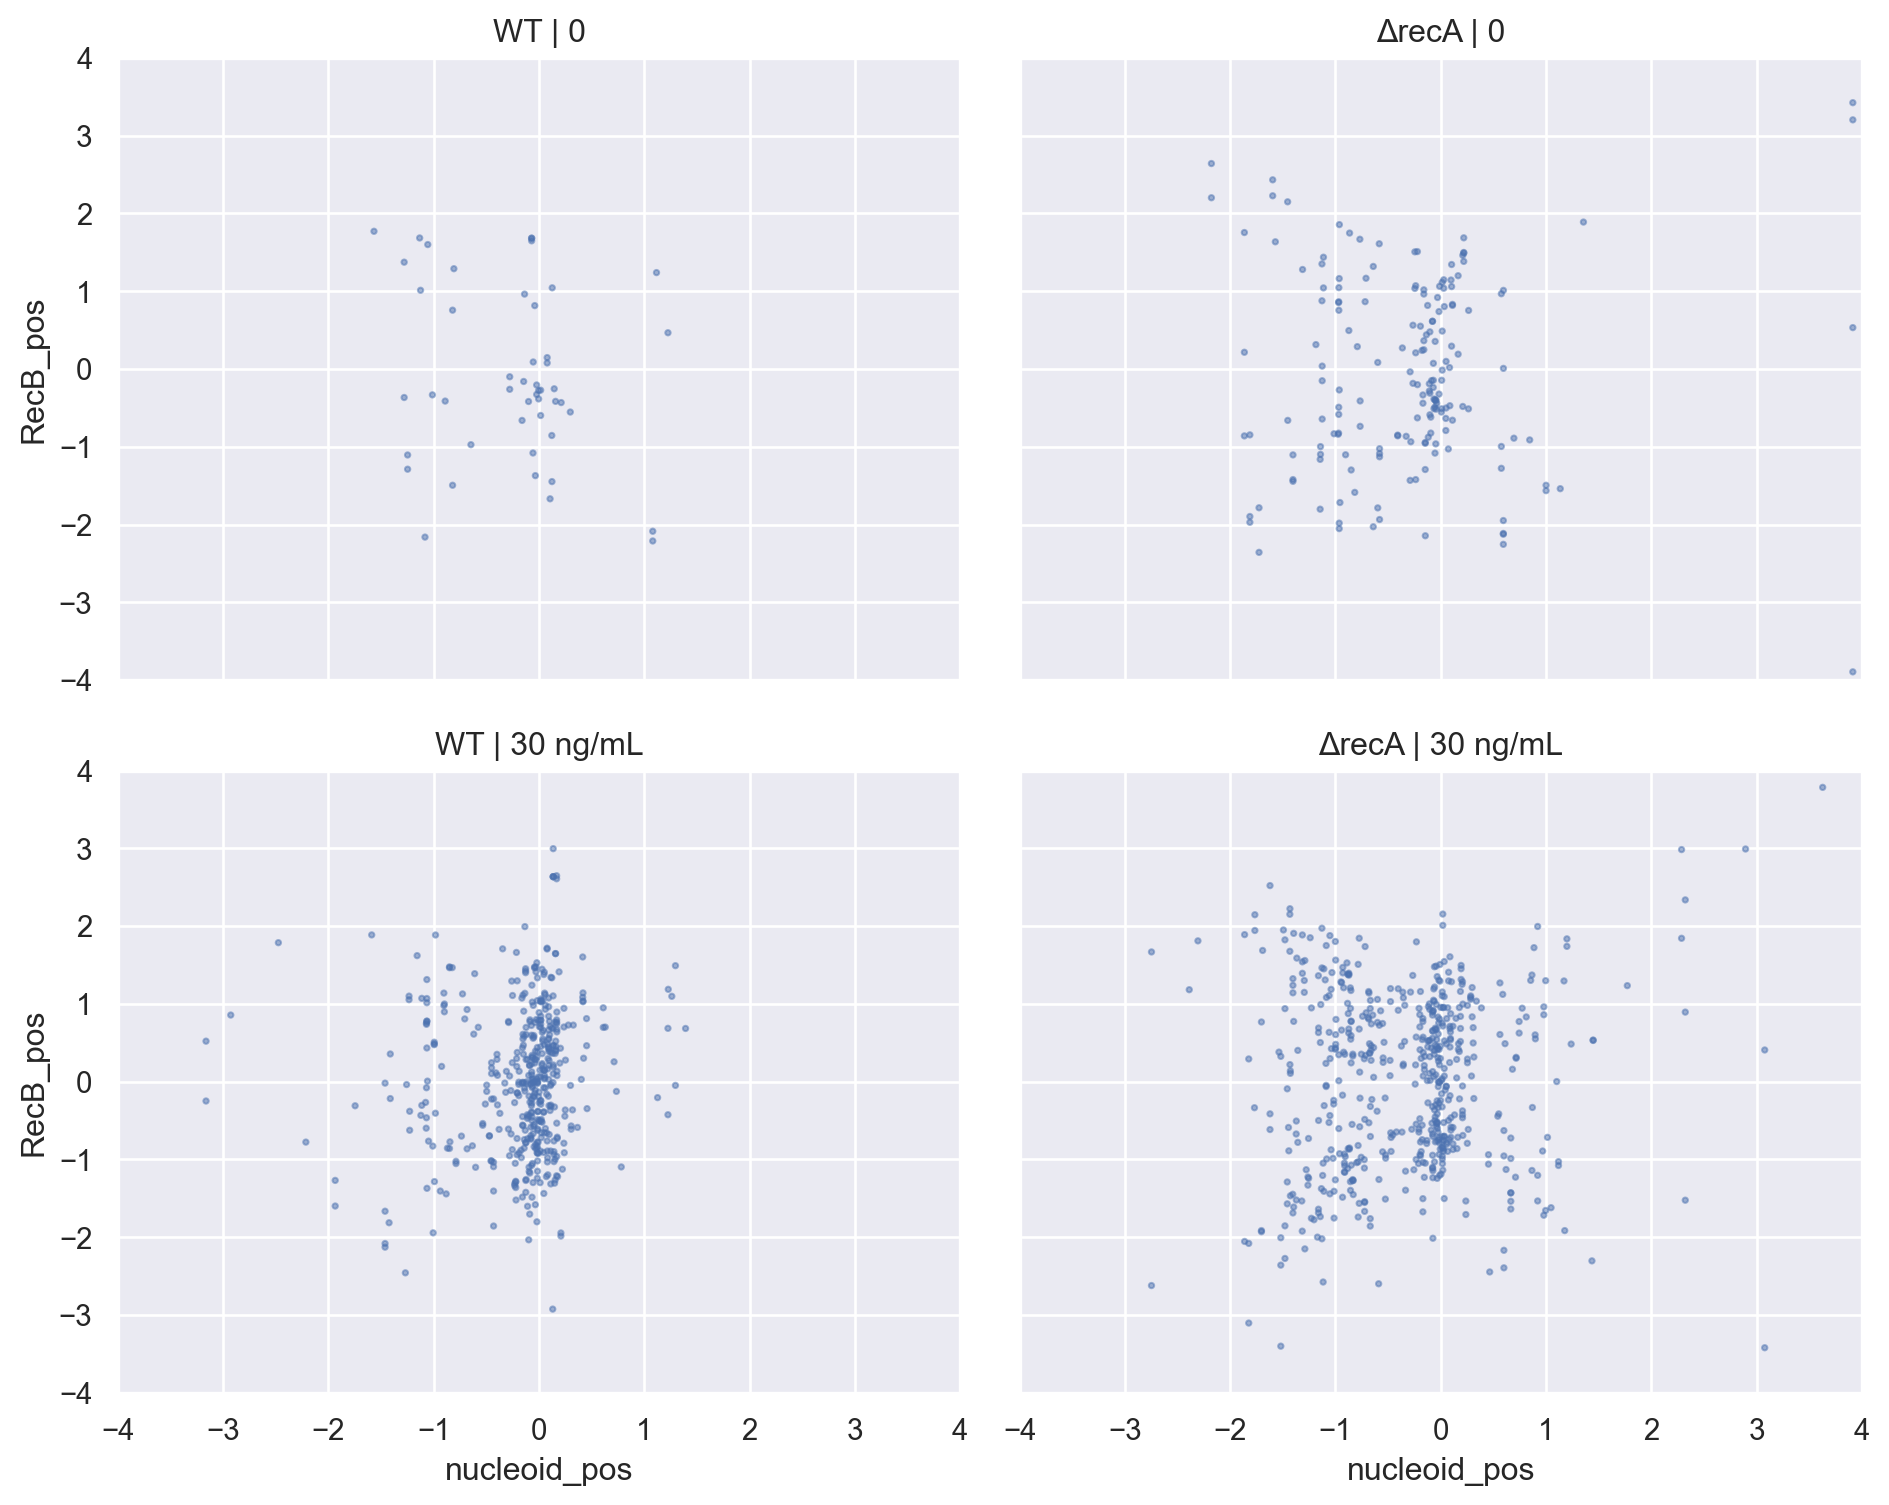

In [17]:
df = (data
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['centerLongCoord', 'TrackLength'], child='RecB_spots', agg='first', rename=['RecB_pos', 'TrackLength'])
      .Bacteria_large
      .query('TrackLength >= 5')
      )


(
    so.Plot(df, x='nucleoid_pos', y='RecB_pos')
    .layout(size=(10,8))
    .facet(row='Cipro', col='Strain')
    .add(so.Dots(marker='.', alpha=.5, fillalpha=.5))
    .limit(x=(-4, 4), y=(-4, 4))
)

DNA-bound RecB distance to the centre of the closest nucleoid:

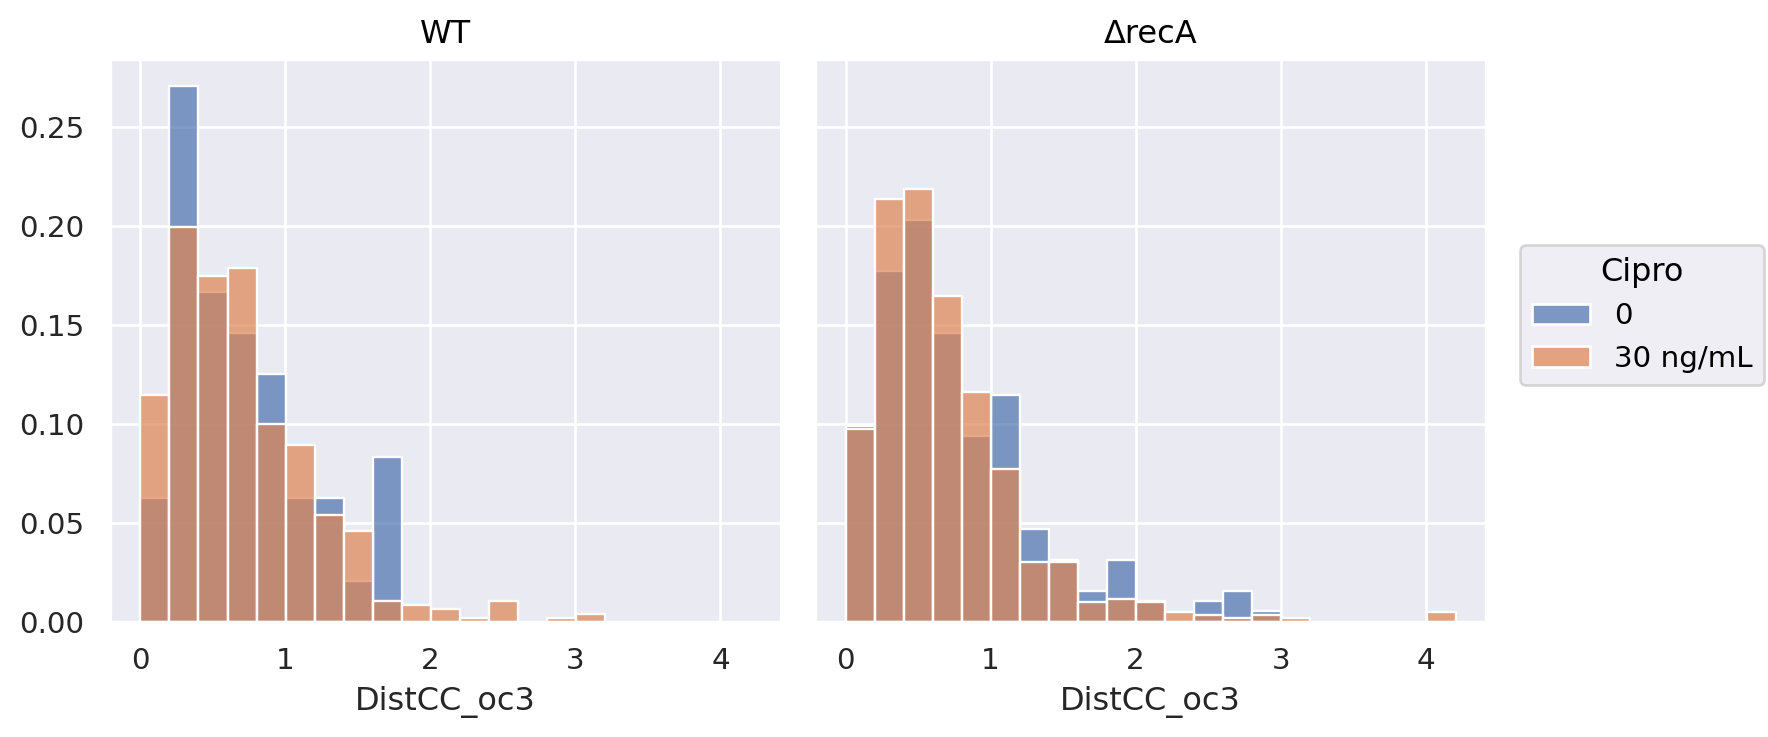

In [3]:
df = data.RecB_spots.query('TrackLength >= 5')

(
    so.Plot(df, x='DistCC_oc3', color='Cipro')
    .facet(col='Strain')
    .layout(size=(8,4))
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.2, common_norm=False))
    # .limit(x=(-5, 5))
)

In [34]:
from pyberries.data import get_histogram, Fit
import numpy as np

df = (data
      .assign(object_name='RecB_spots', spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'))
      .RecB_spots
      .query('TrackLength >= 5')
      .query('spot_in_nucleoid == 1')
      )

hist = get_histogram(df, col='DistCC_oc3', binsize=0.2, density=True, groupby=['Group', 'Cipro', 'Strain'])

def rayleigh(x, sigma, scale):
    return scale*x/(sigma**2)*np.exp(-x**2/(2*sigma**2))

rayleigh_fit = Fit(hist, x='DistCC_oc3', y='proportion',
                    groupby=['Group', 'Cipro', 'Strain'], model=rayleigh,
                    p0=[.5, 1])

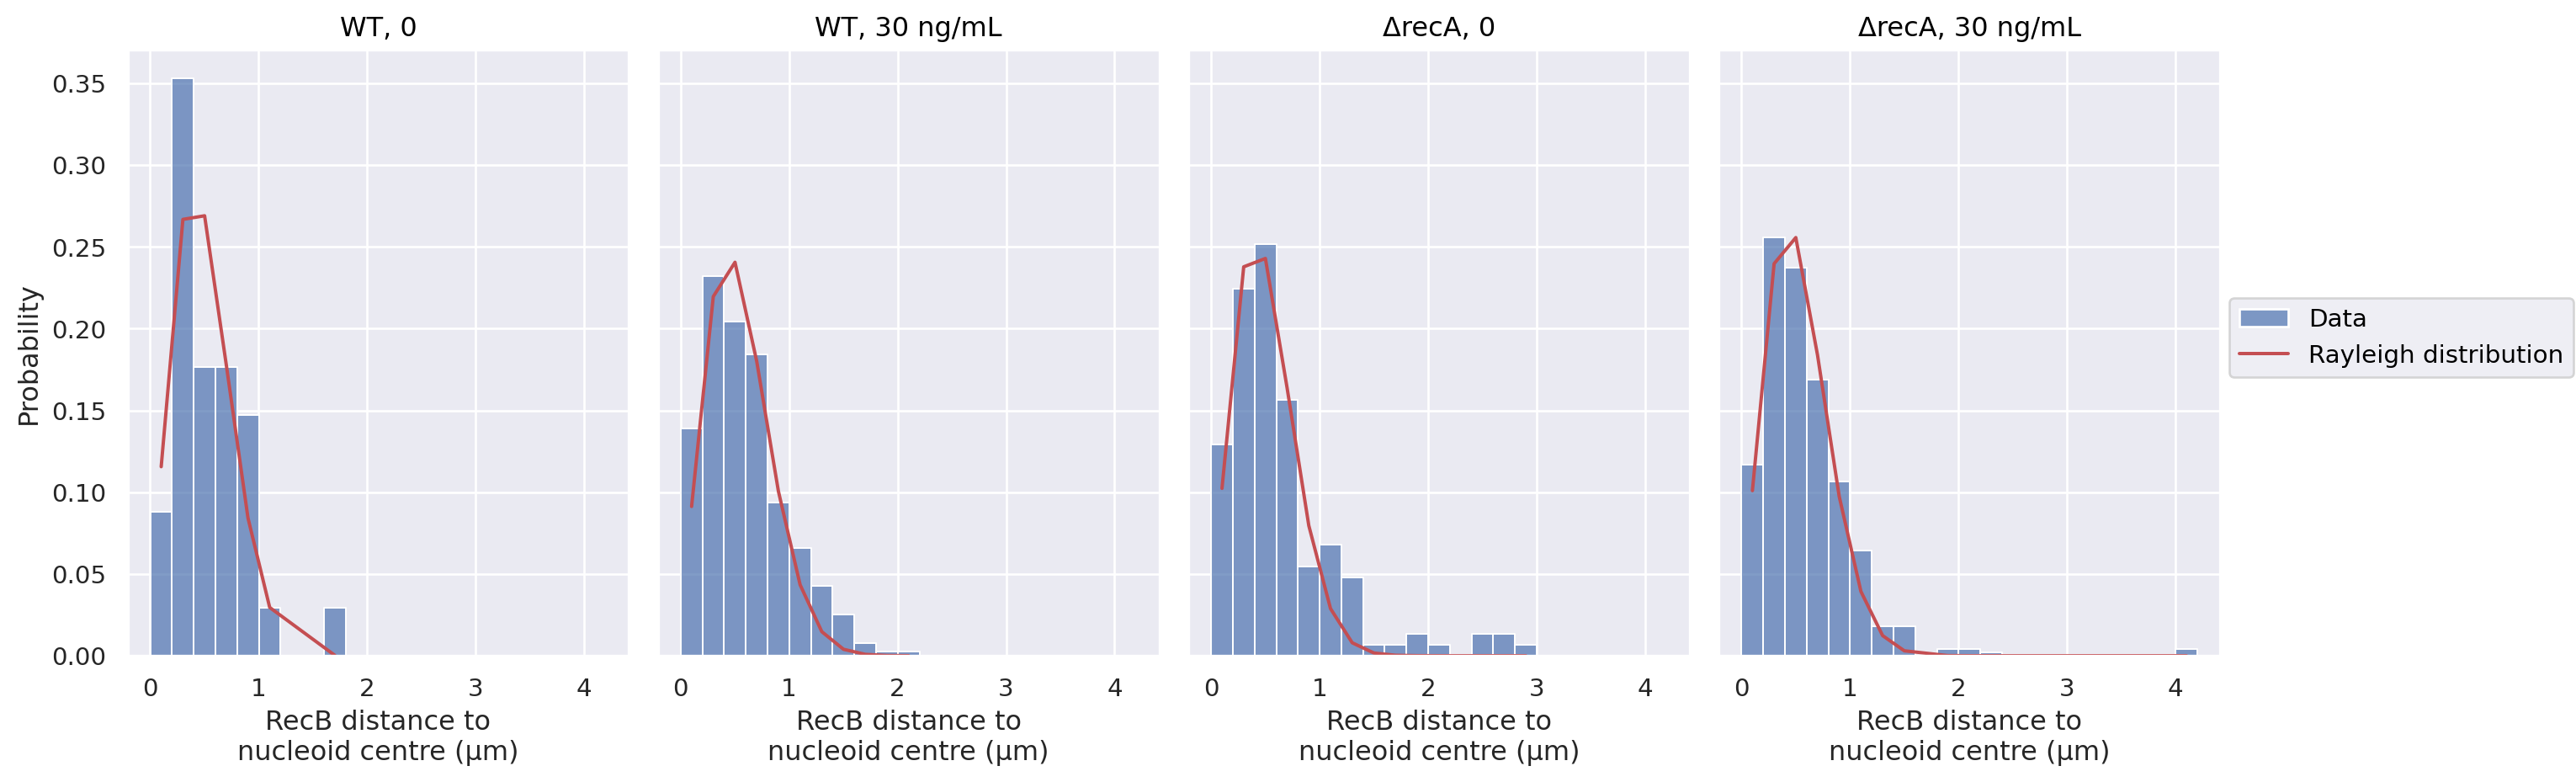

In [35]:
(
    so.Plot(rayleigh_fit.data, x='DistCC_oc3')
    .add(so.Bars(), y='proportion', label='Data')
    .add(so.Line(color='r'), y='Fit', label='Rayleigh distribution')
    .facet(col='Group')
    .layout(size=(14, 5))
    .label(x='RecB distance to\nnucleoid centre (µm)', y='Probability')
)